In [ ]:
import torch
import math
import matplotlib.pyplot as plt
torch.set_printoptions(profile="full")


In [ ]:
# R = P0 + e, ks1, kf1, kb1, E10
# P0 = P1 + P2, k2f, k2b, deltaG2, deltaH2, deltaS2
# P1 = P2 + e, ks2, k3f, k3b, E20

In [ ]:
#physical Constants
F = 96485.332 #C/mol - Faraday constant
T = 298 #K - Temperature
R = 8.314 #J/mol-K - Gas const.
Beta = 0.25 #grid expansion factor 0 < BT < 1

#reaction Constants
DR = 1e-9 #m^2/s - Diffusion coeff of reactant R
DP = 1e-9 #m^2/s - Diffusion coeff of reactant P
ks1 = 1e-9 #m^2/s - Surface rate constant (max value ~ 1 m^2/s) for C-C bond cleavage
ks2 = 1e-9 #m2/s - Surface rate constant for benzyl cation reaction with water
kdiff = 7.9e9  #s-1 - diffusion rate constant
deltaH2 = 10 #kcal/mol - bond dissociation enthalpy for the radical cation
deltaS2 = 20 #cal/(mol K) - bond dissociation entropy for the radical cation


In [ ]:
#calculate reaction constants
deltaG2 = (deltaH2 - T * deltaS2 * 0.001) * 4.184
K2 = math.exp(-deltaG2 * 1000 / (R * T))
print("deltaG2 =", deltaG2)
print("K2 =", K2)
k2f = kdiff * K2 # s-1
#k2f = kdiff
print("k2f =", k2f)
k2b = kdiff # M-1 s-1
#k2b = k2f/K2
print("k2b =", k2b)

deltaG2 = 16.90336
K2 = 0.0010889400743078867
k2f = 8602626.587032305
k2b = 7900000000.0


In [ ]:
#experiment constants
nu = 0.1 #V/s- Sweep rate
Ei = 2.0 #V - initial voltage
E10 = 2.5 #V - thermodynamic reversible potential for bibenzyl oxidation into the radical cation
E20 = 0.97 #V - thermodynamic reversible potential for benzyl radical into benzyl cation
Emax = 4.0 #V - Max voltage (end for forwards sweep
Emin = 1.0 #V - Min voltage (end for backwards sweep)
dE = 0.001 #V - potential step
CR0 = 0.01 #M - bulk conc. of reactant R - MUST have a decimal!
CP00 = 0 #M - bulk conc. of product P0
CP10 = 0 #M - bulk conc. of product P1
CP20 = 0 #M - bulk conc. of product P2
Alpha = 0.5 #Transfer coefficient
n = 1 # # of electrons transferred
VT = Alpha*n*F/(R*T) #V -mod. thermal voltage for n = 1

In [ ]:
tf = (Emax-Emin) / nu #s, timescale of experiment operation
dt = dE / nu #s, timestep

kValues = torch.tensor([ks1 * math.exp(VT * (Emin-E10)), ks1 * math.exp(VT * (Emax-E10)), ks2 * math.exp(VT * (Emin-E20)), kdiff])
print("kValues =", kValues)
print("max kValues =", max(kValues))
Ds = R * T * max(kValues) / (F * nu) #Target dimensionless diffusion coeff
ratio = Ds/max([DR,DP]) #ratio of dt/(dx)^2
dx = math.sqrt(dt/ratio) #Necesary 'base' x-spacing for accuracy
print("dx =", dx)

xmax = 6.0*math.sqrt(max([DR,DP])*tf) #maximum diffusion distance
N = 1 + math.ceil(math.log(1 + (xmax*(math.exp(Beta) - 1)/dx) )/Beta)  #+1 for ghost pt

print("N =", N)
print("Ds =", Ds)
print("xmax =", xmax)
print("ratio =", ratio)

kValues = tensor([2.0668e-22, 4.8385e+03, 1.7935e-09, 7.9000e+09])
max kValues = tensor(7.9000e+09)
dx = 7.021080409107722e-11
N = 63
Ds = tensor(2.0286e+09)
xmax = 0.0010392304845413263
ratio = tensor(2.0286e+18)


In [ ]:
#create the array of space
x = torch.empty(4*(N+1), 1, dtype = torch.float)
x[0] = 0
for k in range(1, 1+N):
  x[k] = dx * (math.exp(Beta*(k-0.5))-1) / (math.exp(Beta)-1)
for k in range(1+N, 2*N+2):
  x[k] = x[k-N-1]
for k in range(2*(N+1), 3*(N+1)):
  x[k] = x[k-2*N-2]
for k in range(3*(N+1), 4*(N+1)):
  x[k] = x[k-3*(N+1)]

print(x.shape)

torch.Size([256, 1])


In [ ]:
#calculate the normalized rate constant
dx1 = dx * (math.exp(Beta/2)-1)/(math.exp(Beta)-1)

k1f = ks1 * math.exp((Ei-E10)*VT) * dx1 / DR
k1b = ks1 * math.exp(-(Ei-E10)*VT) * dx1 / DP
k2fs = k2f * dt
k2bs = k2b * dt
k3f = ks2 * math.exp((Ei-E20)*VT) * dx1 / DR
k3b = ks2 * math.exp(-(Ei-E20)*VT) * dx1 / DP

print(k1f)
print(k1b)
print(k2fs)
print(k2bs)
print(k3f)
print(k3b)

1.946013185265385e-15
5.566983756097551e-07
86026.26587032306
79000000.0
0.01688695193003405
6.41526300093057e-20


In [ ]:
#create tensors for the new concentration
Cnew = torch.empty(4*(N+1), 1, dtype = torch.float)
for i in range(0, N+1):
  Cnew[i] = CR0
for i in range(N+1, 2*N+2):
  Cnew[i] = CP00
for i in range(2*N+2, 3*N+3):
  Cnew[i] = CP10
for i in range(3*(N+1), 4*(N+1)):
  Cnew[i] = CP20

#create tensors for the old concentrations
ColdR = torch.empty(N+1, 1, dtype = torch.float)
ColdR.fill_(CR0)

Cold0 = torch.empty(N+1, 1, dtype = torch.float)
Cold0.fill_(CP00)

Cold1 = torch.empty(N+1, 1, dtype = torch.float)
Cold1.fill_(CP10)

Cold2 = torch.empty(N+1, 1, dtype = torch.float)
Cold2.fill_(CP20)

#create tensors for the old concentration
Cold = torch.empty(4*N+4, 1, dtype = torch.float)

Cold[0:N] = ColdR[0:N]

Cold[N+1 : 2*N+1] = Cold0[0 : N] - k2bs * Cold1[0 : N] * Cold2[0 : N]

Cold[2*N+2 : 3*N+2] = Cold1[0 : N] + k2bs * Cold1[0 : N] * Cold2[0 : N]

Cold[3*N+3 : 4*N+3] = Cold2[0 : N] + k2bs * Cold1[0 : N] * Cold2[0 : N]


Cold[0] = 0
Cold[N+1] = 0
Cold[2*N+2] = 0
Cold[3*N+3] = 0

Cold[N] = CR0
Cold[2*N+1] = CP00
Cold[3*N+2] = CP10
Cold[4*N+3] = CP20

print("Cnew =", Cnew)
print("ColdR =", ColdR)
print("Cold0 =", Cold0)
print("Cold1 =", Cold1)
print("Cold2 =", Cold2)
print("Cold =", Cold)

Cnew = tensor([[0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
   

In [ ]:
#create tensors for the diffusion coefficients
D1 = torch.empty(N, 1, dtype = torch.float)
D2 = torch.empty(N, 1, dtype = torch.float)
D3 = torch.empty(N, 1, dtype = torch.float)

#set values for the diffusion coefficients
D1[0] = Ds * (math.exp(Beta)-1) / (math.exp(Beta/2) - 1)
D2[0] = Ds * math.exp(2*Beta*(3/4 - 1))
D3[0] = D1[0] + D2[0] + 1

for k in range(1, N):
  D1[k] = Ds * math.exp(2 * Beta * (5/4 - k - 1))
  D2[k] = Ds * math.exp(2 * Beta * (3/4 - k - 1))
  D3[k] = D1[k] + D2[k] + 1

In [ ]:
#create a tensor size (5N+5)*(5N+5) with uninitialized memory
Dopt = torch.empty(4*(N+1), 4*(N+1), dtype=torch.float).fill_(0)
Drat = DR/DP

#set values for the operator Dopt

#set values for row 0
Dopt[0] = 0
Dopt[0, 0] = 1 + k1f
Dopt[0, 1] = -1
Dopt[0, N+1] = - k1b

print(Dopt[0])

tensor([ 1.0000e+00, -1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -5.5670e-07,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0

In [ ]:
#set values for row N+1
Dopt[N+1] = 0
Dopt[N+1, 0] = -Drat
Dopt[N+1, 1] = Drat
Dopt[N+1, N+1] = -1
Dopt[N+1, N+2] = 1

print(Dopt[N+1])

tensor([-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

In [ ]:
#set values for row 2*(N+1)
Dopt[2*N+2] = 0
Dopt[2*(N+1), 2*(N+1)] = 1 + k3f
Dopt[2*(N+1), 2*(N+1)+1] = -1
Dopt[2*(N+1), 3*(N+1)] = -k3b

print(Dopt[2*(N+1)])

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0

In [ ]:
#set values for row 3*(N+1)
Dopt[3*N+3] = 0
Dopt[3*(N+1), 2*(N+1)] = -Drat
Dopt[3*(N+1), 2*(N+1)+1] = Drat
Dopt[3*(N+1), 3*(N+1)] = -1
Dopt[3*(N+1), 3*(N+1)+1] = 1

print(Dopt[3*(N+1)])

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

In [ ]:
#set values for row N
Dopt[N] = 0
Dopt[N, N] = 1

#set values for row 2N+1
Dopt[2*N+1] = 0
Dopt[2*N+1, 2*N+1] = 1

#set values for row 3*N+2
Dopt[3*N+2] = 0
Dopt[3*N+2, 3*N+2] = 1

#set values for row 4N+3
Dopt[4*N+3] = 0
Dopt[4*N+3, 4*N+3] = 1

print(Dopt[N])
print(Dopt[2*N+1])
print(Dopt[3*N+2])
print(Dopt[4*N+3])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
#set values for other rows for Dopt
for i in range(1, N):
  Dopt[i] = 0
  Dopt[i, i] = D3[i-1]
  Dopt[i, i-1] = -D1[i-1]
  Dopt[i, i+1] = -D2[i-1]

for i in range(N+2, 2*N+1):
  Dopt[i] = 0
  Dopt[i, i] = D3[i-N-2] + k2fs
  Dopt[i, i-1] = -D1[i-N-2]
  Dopt[i, i+1] = -D2[i-N-2]
  Dopt[i, i+N+1] = -k2bs * Cold2[i-N-1]
  Dopt[i, i+2*N+2] = -k2bs * Cold1[i-N-1]

for i in range(2*N+3, 3*N+2):
  Dopt[i] = 0
  Dopt[i, i] = D3[i-2*N-3] + k2bs * Cold2[i-2*N-2]
  Dopt[i, i-1] = -D1[i-2*N-3]
  Dopt[i, i+1] = -D2[i-2*N-3]
  Dopt[i, i-N-1] = -k2fs
  Dopt[i, i+N+1] = k2bs * Cold1[i-2*N-2]

for i in range(3*N+4, 4*N+3):
  Dopt[i] = 0
  Dopt[i, i] = D3[i-3*N-4] + k2bs * Cold1[i-3*N-3]
  Dopt[i, i-1] = -D1[i-3*N-4]
  Dopt[i, i+1] = -D2[i-3*N-4]
  Dopt[i, i-N-1] = k2bs * Cold2[i-3*N-3]

print(Dopt.shape)

torch.Size([256, 256])


In [ ]:
#Initialize potential vector

Evt = torch.cat([torch.arange((Ei+dE),(Emax+dE),dE), torch.arange(Emax, (Emin-dE), -dE), torch.arange(Emin, (Ei+2*dE), dE)])

Evt = Evt.reshape(len(Evt),1)
print(Evt.shape)
Istor = 0.0*Evt
count = 0

torch.Size([6004, 1])


tensor([2.0010]) tensor([0.]) 1.9842729574426578e-15 5.459643921915981e-07 0.0172189743320837 6.2915616125511e-20 86026.26587032306 79000000.0


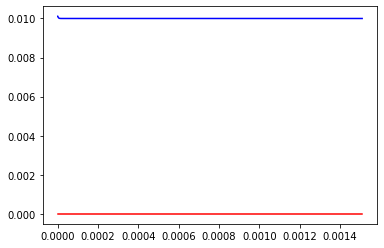

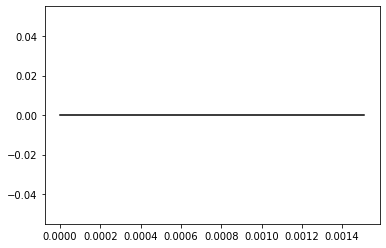

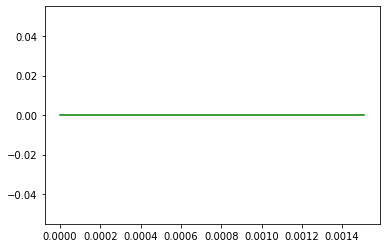

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


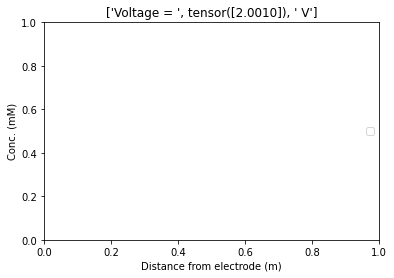

0 tensor([2.0010])
tensor([2.0020]) tensor([-2.8295e-08]) 2.023295387221189e-15 5.354346112755574e-07 0.017557583488198136 6.170224848314728e-20 86026.26587032306 79000000.0
tensor([2.0030]) tensor([-2.8295e-08]) 2.063075389020478e-15 5.251104176405122e-07 0.017902817207600116 6.051239682503736e-20 86026.26587032306 79000000.0
tensor([2.0040]) tensor([0.]) 2.1036375052619524e-15 5.14985294016948e-07 0.018254804418774848 5.934560317930335e-20 86026.26587032306 79000000.0
tensor([2.0050]) tensor([2.8295e-08]) 2.145007341261917e-15 5.050529936718401e-07 0.01861378305478792 5.820108550549285e-20 86026.26587032306 79000000.0
tensor([2.0060]) tensor([0.]) 2.1871824071183934e-15 4.953141428106611e-07 0.01897974856238886 5.707885832055786e-20 86026.26587032306 79000000.0
tensor([2.0070]) tensor([0.]) 2.2301845909023632e-15 4.857635478120087e-07 0.01935290931624143 5.597826980170047e-20 86026.26587032306 79000000.0
tensor([2.0080]) tensor([0.]) 2.2740322404344904e-15 4.7639710637761924e-07 0.01

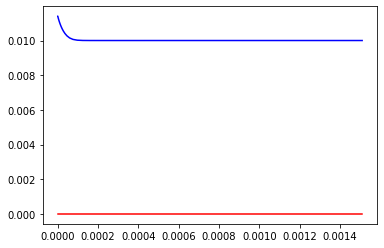

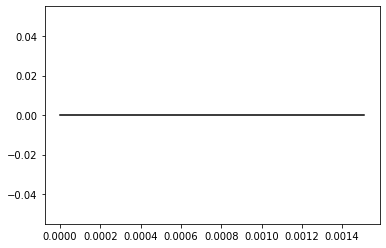

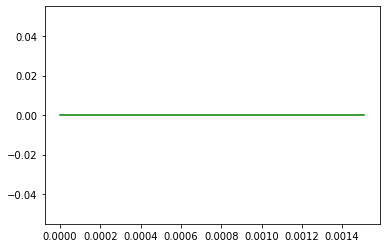

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


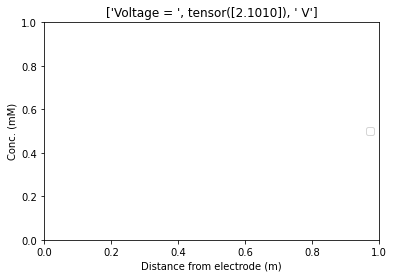

100 tensor([2.1010])
tensor([2.1020]) tensor([0.]) 1.4180973296071601e-14 7.639407793345975e-08 0.1230585226887277 8.803472977590366e-21 86026.26587032306 79000000.0
tensor([2.1030]) tensor([-2.8295e-08]) 1.445978535030564e-14 7.492105538962973e-08 0.12547797576754813 8.633725341244991e-21 86026.26587032306 79000000.0
tensor([2.1040]) tensor([-2.8295e-08]) 1.4744149432539644e-14 7.347608514883333e-08 0.12794572981206154 8.467202311040145e-21 86026.26587032306 79000000.0
tensor([2.1050]) tensor([2.8295e-08]) 1.503403409034087e-14 7.205932703374908e-08 0.1304612702488563 8.30393861017847e-21 86026.26587032306 79000000.0
tensor([2.1060]) tensor([0.]) 1.532962547887036e-14 7.066985300101647e-08 0.1330262687152269 8.14382294275687e-21 86026.26587032306 79000000.0
tensor([2.1070]) tensor([0.]) 1.5631095713364386e-14 6.930687387616478e-08 0.13564221503827745 7.986764141581534e-21 86026.26587032306 79000000.0
tensor([2.1080]) tensor([0.]) 1.5938418618131394e-14 6.797050605258952e-08 0.13830907

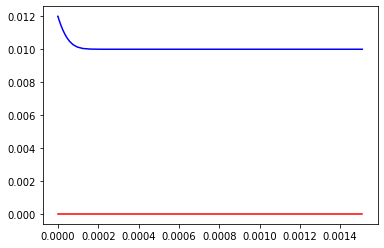

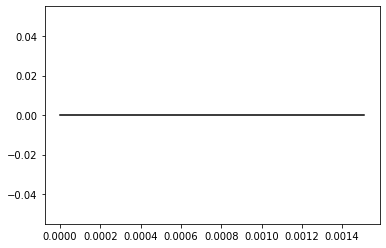

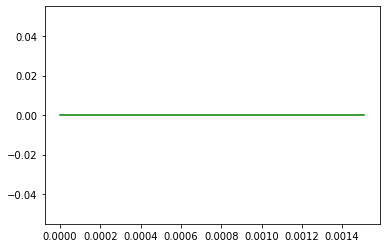

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


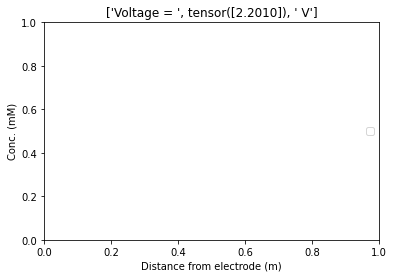

200 tensor([2.2010])
tensor([2.2020]) tensor([2.8295e-08]) 9.939226323653946e-14 1.089966506320723e-08 0.8624991028242132 1.2560504417976216e-21 86026.26587032306 79000000.0
tensor([2.2030]) tensor([0.]) 1.013468973498198e-13 1.0689447901034649e-08 0.8794600487972027 1.2318267107574052e-21 86026.26587032306 79000000.0
tensor([2.2040]) tensor([0.]) 1.0333952753349325e-13 1.0483330096523662e-08 0.8967511089876796 1.2080747581961334e-21 86026.26587032306 79000000.0
tensor([2.2050]) tensor([0.]) 1.0537128553441764e-13 1.0281191632596633e-08 0.9143821286372812 1.1847807882760446e-21 86026.26587032306 79000000.0
tensor([2.2060]) tensor([2.8295e-08]) 1.0744350224987381e-13 1.0082902702044764e-08 0.9323651267082382 1.1619293215922822e-21 86026.26587032306 79000000.0
tensor([2.2070]) tensor([-2.8295e-08]) 1.095559484798294e-13 9.888485236854685e-09 0.95069635340519 1.139525123108031e-21 86026.26587032306 79000000.0
tensor([2.2080]) tensor([0.]) 1.1170992750591512e-13 9.697816508698758e-09 0.969

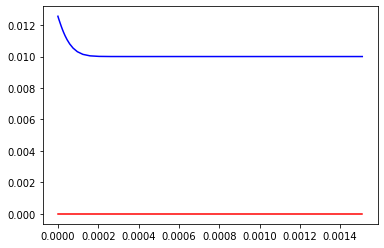

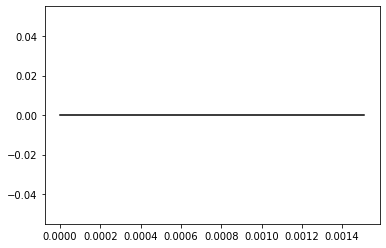

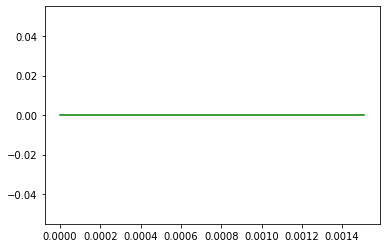

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


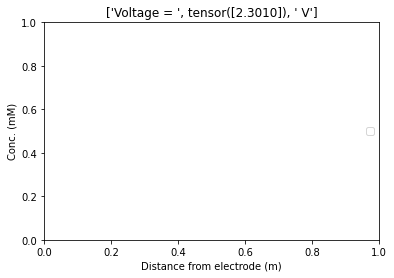

300 tensor([2.3010])
tensor([2.3020]) tensor([0.]) 6.966285914472992e-13 1.555121900612317e-09 6.045152533083043 1.7920844399271067e-22 86026.26587032306 79000000.0
tensor([2.3030]) tensor([0.]) 7.103251725055154e-13 1.5251358407180675e-09 6.164006250717071 1.757529656992768e-22 86026.26587032306 79000000.0
tensor([2.3040]) tensor([0.]) 7.242908726295876e-13 1.4957283324850648e-09 6.285196750776048 1.7236411557341345e-22 86026.26587032306 79000000.0
tensor([2.3050]) tensor([2.8295e-08]) 7.385346739223518e-13 1.4668808620708118e-09 6.40879442429299 1.690399640603105e-22 86026.26587032306 79000000.0
tensor([2.3060]) tensor([0.]) 7.53055180473289e-13 1.4385962771964915e-09 6.534797703566903 1.6578055332318586e-22 86026.26587032306 79000000.0
tensor([2.3070]) tensor([0.]) 7.678609950979812e-13 1.4108574156891093e-09 6.6632910419729745 1.6258368009565915e-22 86026.26587032306 79000000.0
tensor([2.3080]) tensor([0.]) 7.829616402226828e-13 1.3836468142223303e-09 6.79432389637844 1.59448150496

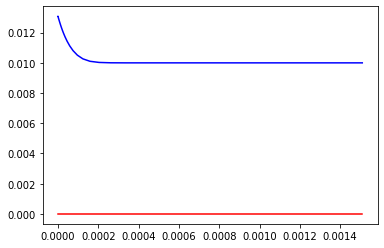

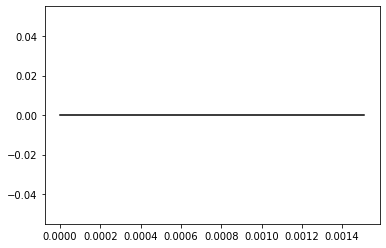

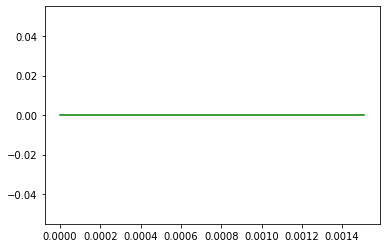

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


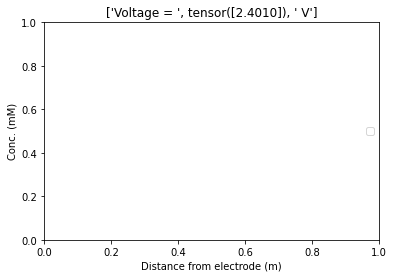

400 tensor([2.4010])
tensor([2.4020]) tensor([-2.8295e-08]) 4.882563939838578e-12 2.218798140692084e-10 42.36950499250548 2.556891753500618e-23 86026.26587032306 79000000.0
tensor([2.4030]) tensor([0.]) 4.9785837478830785e-12 2.1760051332129311e-10 43.20277885327434 2.5075756882020536e-23 86026.26587032306 79000000.0
tensor([2.4040]) tensor([0.]) 5.0764682664369765e-12 2.1340473776127267e-10 44.052188500215664 2.459224878571247e-23 86026.26587032306 79000000.0
tensor([2.4050]) tensor([0.]) 5.176277303982163e-12 2.0928986519307592e-10 44.9182983865274 2.4118063641461058e-23 86026.26587032306 79000000.0
tensor([2.4060]) tensor([0.]) 5.27804869871208e-12 2.052543356442991e-10 45.801436855543116 2.3653021685089208e-23 86026.26587032306 79000000.0
tensor([2.4070]) tensor([0.]) 5.381846053778897e-12 2.012956833634678e-10 46.70220593755458 2.3196813885000209e-23 86026.26587032306 79000000.0
tensor([2.4080]) tensor([-2.8295e-08]) 5.48765915979109e-12 1.9741429771918398e-10 47.6204178051644 2.2

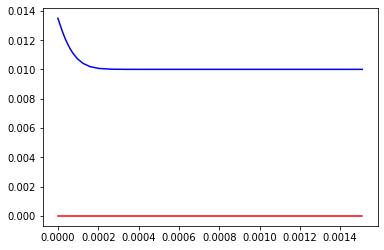

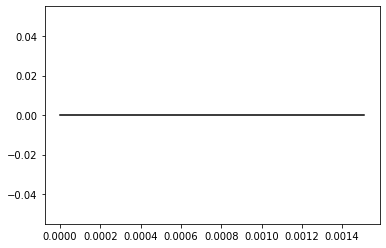

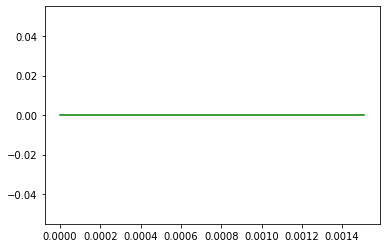

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


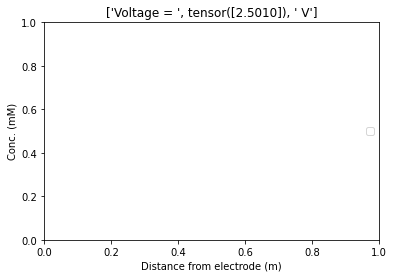

500 tensor([2.5010])
tensor([2.5020]) tensor([0.]) 3.422130806939973e-11 3.1656954110445494e-11 296.9627673724331 3.648074769567801e-24 86026.26587032306 79000000.0
tensor([2.5030]) tensor([0.]) 3.489413747804877e-11 3.104654413177329e-11 302.8019285971428 3.577726153104256e-24 86026.26587032306 79000000.0
tensor([2.5040]) tensor([2.8295e-08]) 3.558019546966795e-11 3.044790408967688e-11 308.75531599697575 3.508740815212447e-24 86026.26587032306 79000000.0
tensor([2.5050]) tensor([0.]) 3.6279910533572734e-11 2.9860668431083954e-11 314.82695388778683 3.441072518646352e-24 86026.26587032306 79000000.0
tensor([2.5060]) tensor([0.]) 3.6993214382176074e-11 2.9284894466331564e-11 321.0167652575054 3.37472212170413e-24 86026.26587032306 79000000.0
tensor([2.5070]) tensor([0.]) 3.772054230572463e-11 2.87202227998719e-11 327.3282744816153 3.309651086109434e-24 86026.26587032306 79000000.0
tensor([2.5080]) tensor([0.]) 3.846217088195144e-11 2.8166438719161555e-11 333.7638742611019 3.2458347433518

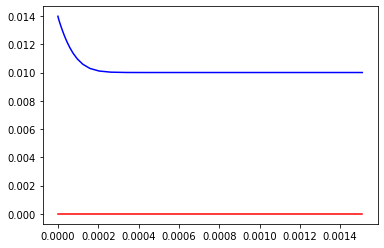

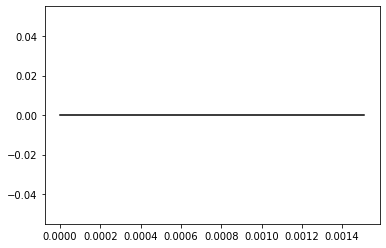

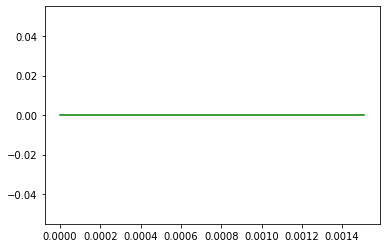

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


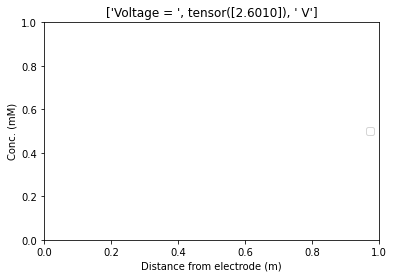

600 tensor([2.6010])
tensor([2.6020]) tensor([-2.8295e-08]) 2.3985194630286415e-10 4.516712896648563e-12 2081.3683996417817 5.204952565527833e-25 86026.26587032306 79000000.0
tensor([2.6030]) tensor([0.]) 2.445677035296165e-10 4.4296215874685845e-12 2122.2901746854386 5.104591219779718e-25 86026.26587032306 79000000.0
tensor([2.6040]) tensor([0.]) 2.493773372049052e-10 4.344189377009262e-12 2164.028895207304 5.006136385478467e-25 86026.26587032306 79000000.0
tensor([2.6050]) tensor([-2.8295e-08]) 2.542804045711367e-10 4.260424160404909e-12 2206.5758578943937 4.90960859231994e-25 86026.26587032306 79000000.0
tensor([2.6060]) tensor([-2.8295e-08]) 2.5927981049834353e-10 4.1782751116262746e-12 2249.9593362296364 4.814942037876176e-25 86026.26587032306 79000000.0
tensor([2.6070]) tensor([2.8295e-08]) 2.64378770376929e-10 4.097690512774028e-12 2294.2045286225984 4.72208282058804e-25 86026.26587032306 79000000.0
tensor([2.6080]) tensor([-2.8295e-08]) 2.695767845023843e-10 4.0186783188773576e

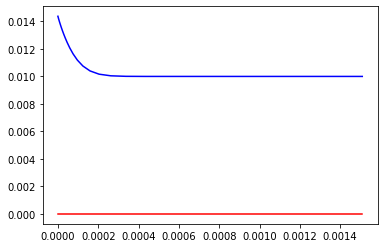

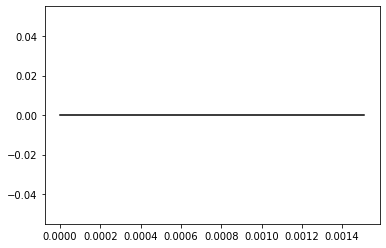

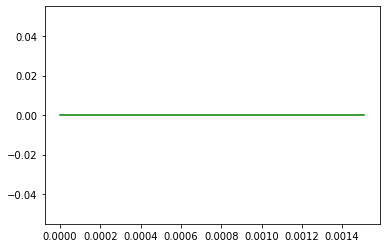

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


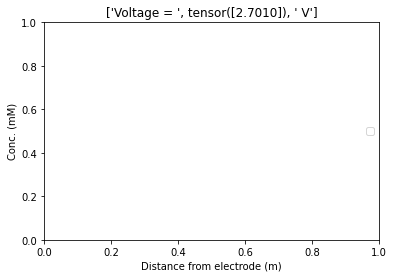

700 tensor([2.7010])
tensor([2.7020]) tensor([0.]) 1.6810860448471371e-09 6.444300590520427e-13 14587.977444282995 7.426268537157394e-26 86026.26587032306 79000000.0
tensor([2.7030]) tensor([0.]) 1.7141460439216904e-09 6.320012130786081e-13 14874.90509138968 7.283020446157311e-26 86026.26587032306 79000000.0
tensor([2.7040]) tensor([0.]) 1.7478478618283189e-09 6.198150324246103e-13 15167.360535630285 7.142590014969843e-26 86026.26587032306 79000000.0
tensor([2.7050]) tensor([0.]) 1.782212715942654e-09 6.078636794931633e-13 15465.565945086833 7.004867348527689e-26 86026.26587032306 79000000.0
tensor([2.7060]) tensor([2.8295e-08]) 1.8172614577487753e-09 5.961400735887783e-13 15769.694526296256 6.869774029838764e-26 86026.26587032306 79000000.0
tensor([2.7070]) tensor([0.]) 1.852990627357722e-09 5.846453636396429e-13 16079.742421720894 6.737311772413724e-26 86026.26587032306 79000000.0
tensor([2.7080]) tensor([-2.8295e-08]) 1.8894222680147953e-09 5.733722934739552e-13 16395.886167467615 6

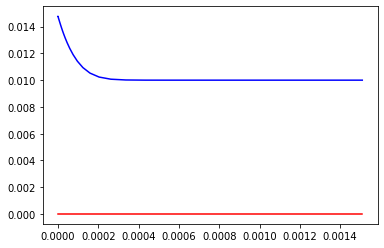

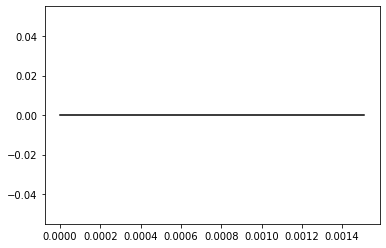

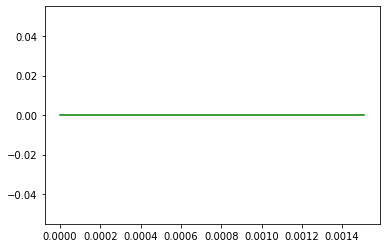

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


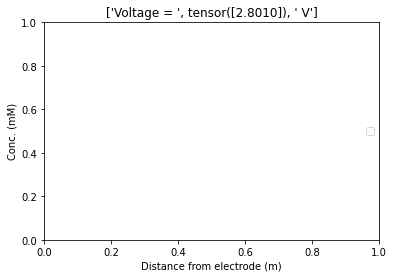

800 tensor([2.8010])
tensor([2.8020]) tensor([0.]) 1.1782532818842637e-08 9.194477926001812e-14 102245.38032689296 1.0595514200140941e-26 86026.26587032306 79000000.0
tensor([2.8030]) tensor([-2.8295e-08]) 1.2014189145296025e-08 9.017190973529595e-14 104255.62630435199 1.0391212614174118e-26 86026.26587032306 79000000.0
tensor([2.8040]) tensor([0.]) 1.2250400065775247e-08 8.843322449354212e-14 106305.39571922181 1.0190850349814547e-26 86026.26587032306 79000000.0
tensor([2.8050]) tensor([0.]) 1.2491314691221597e-08 8.672765084637053e-14 108396.29263656074 9.994275198919555e-27 86026.26587032306 79000000.0
tensor([2.8060]) tensor([0.]) 1.2736906374981992e-08 8.505537744081417e-14 110527.4716741608 9.801566639886056e-27 86026.26587032306 79000000.0
tensor([2.8070]) tensor([-2.8295e-08]) 1.2987332828608959e-08 8.341530885895064e-14 112700.55181354054 9.612573866938652e-27 86026.26587032306 79000000.0
tensor([2.8080]) tensor([0.]) 1.3242739868962904e-08 8.180651359704212e-14 114916.7952440

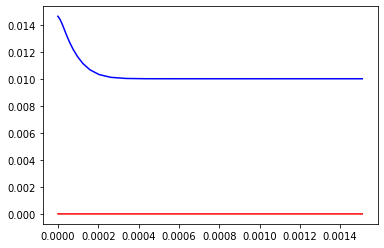

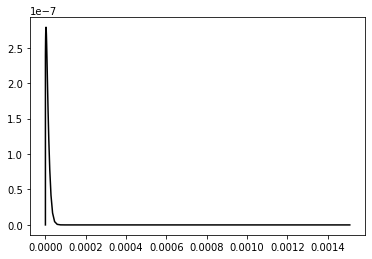

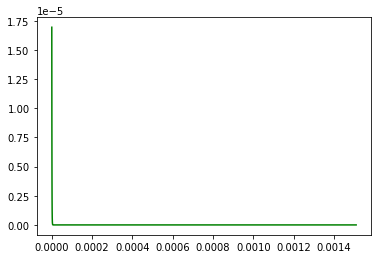

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


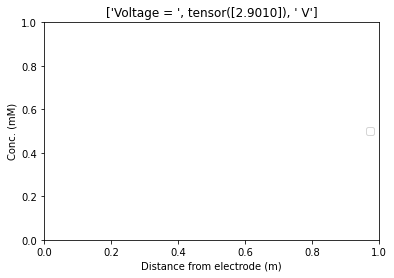

900 tensor([2.9010])
tensor([2.9020]) tensor([0.]) 8.25819623994347e-08 1.3118389872021508e-14 716622.8463747323 1.5117329633472364e-27 86026.26587032306 79000000.0
tensor([2.9030]) tensor([2.8295e-08]) 8.420600752720708e-08 1.2865381116690231e-14 730715.1524891065 1.4825782323824957e-27 86026.26587032306 79000000.0
tensor([2.9040]) tensor([2.8295e-08]) 8.586158147458993e-08 1.2617312196526597e-14 745081.7399208639 1.4539913154595208e-27 86026.26587032306 79000000.0
tensor([2.9050]) tensor([2.8295e-08]) 8.754974740110714e-08 1.2374020614692323e-14 759733.6869140593 1.425950168871415e-27 86026.26587032306 79000000.0
tensor([2.9060]) tensor([2.8295e-08]) 8.927106260359301e-08 1.2135426055842675e-14 774670.8076248069 1.3984551482893828e-27 86026.26587032306 79000000.0
tensor([2.9070]) tensor([2.8295e-08]) 9.102665462465911e-08 1.190137530176714e-14 789904.6202420644 1.371485051980602e-27 86026.26587032306 79000000.0
tensor([2.9080]) tensor([2.8295e-08]) 9.281632928492974e-08 1.16718942399

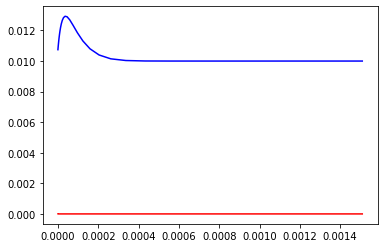

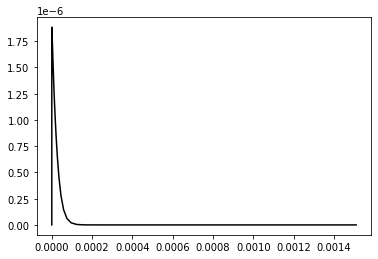

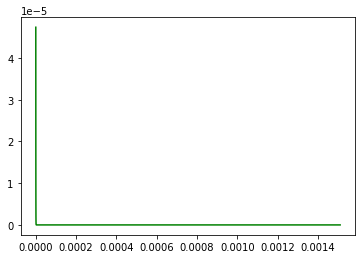

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


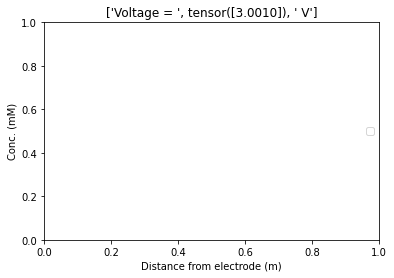

1000 tensor([3.0010])
tensor([3.0020]) tensor([1.6977e-07]) 5.788070475102372e-07 1.8716813898732713e-15 5022723.387006609 2.1568824234974347e-28 86026.26587032306 79000000.0
tensor([3.0030]) tensor([1.6977e-07]) 5.901869703513708e-07 1.835591826955163e-15 5121475.129651001 2.115293644364976e-28 86026.26587032306 79000000.0
tensor([3.0040]) tensor([1.9807e-07]) 6.017906338059388e-07 1.800198139178341e-15 5222168.4298775885 2.074506775680155e-28 86026.26587032306 79000000.0
tensor([3.0050]) tensor([1.9807e-07]) 6.136253628239341e-07 1.7654784902742788e-15 5324882.086112834 2.034490833097951e-28 86026.26587032306 79000000.0
tensor([3.0060]) tensor([1.9807e-07]) 6.256904451154839e-07 1.7314350692257296e-15 5429574.56962484 1.9952619956875545e-28 86026.26587032306 79000000.0
tensor([3.0070]) tensor([1.6977e-07]) 6.379921422328169e-07 1.6980497210529446e-15 5536325.411599373 1.956789564577711e-28 86026.26587032306 79000000.0
tensor([3.0080]) tensor([1.6977e-07]) 6.505357029636156e-07 1.6653

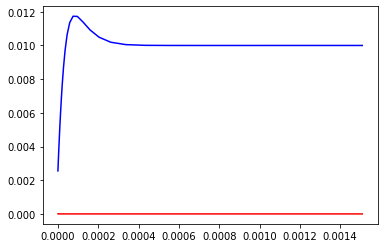

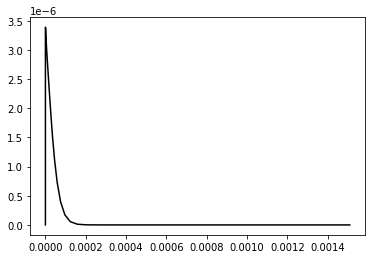

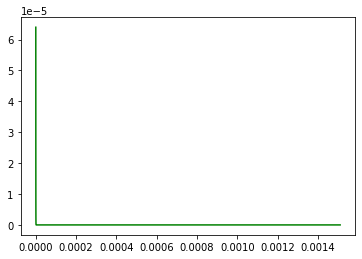

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


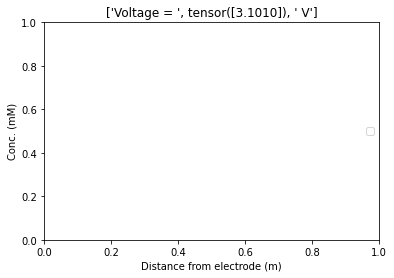

1100 tensor([3.1010])
tensor([3.1020]) tensor([3.1125e-07]) 4.0567696749868575e-06 2.6704557220294124e-16 35203530.16089163 3.07736858832389e-29 86026.26587032306 79000000.0
tensor([3.1030]) tensor([3.1125e-07]) 4.136533750808841e-06 2.6189617791479955e-16 35895666.614118524 3.01803109216059e-29 86026.26587032306 79000000.0
tensor([3.1040]) tensor([2.9710e-07]) 4.21788223525601e-06 2.5684509873155586e-16 36601550.78270832 2.9598264444691494e-29 86026.26587032306 79000000.0
tensor([3.1050]) tensor([3.1125e-07]) 4.30080999951989e-06 2.518926386595413e-16 37321173.71329415 2.9027553835117163e-29 86026.26587032306 79000000.0
tensor([3.1060]) tensor([3.0418e-07]) 4.3853682061959175e-06 2.470356713996769e-16 38054945.1471852 2.846784760725209e-29 86026.26587032306 79000000.0
tensor([3.1070]) tensor([2.9003e-07]) 4.4716102336535866e-06 2.4227120042778105e-16 38803439.30366163 2.791872057202356e-29 86026.26587032306 79000000.0
tensor([3.1080]) tensor([3.1125e-07]) 4.559526542989301e-06 2.37599

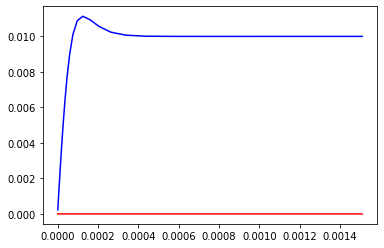

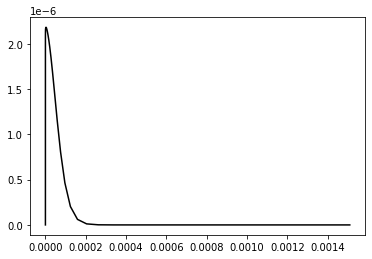

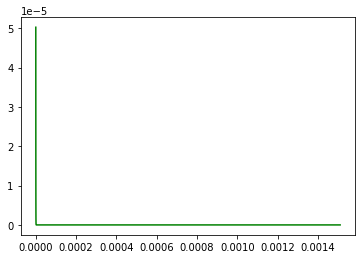

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


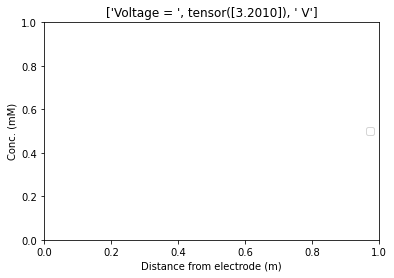

1200 tensor([3.2010])
tensor([3.2020]) tensor([1.9674e-07]) 2.843330253436521e-05 3.810118004558389e-17 246736369.95315108 4.39068783964887e-30 86026.26587032306 79000000.0
tensor([3.2030]) tensor([1.9630e-07]) 2.8992467818232682e-05 3.73663389382506e-17 251588412.38037652 4.3060106342040105e-30 86026.26587032306 79000000.0
tensor([3.2040]) tensor([1.9542e-07]) 2.9562488601781805e-05 3.664584513656641e-17 256534891.06084102 4.222982591851317e-30 86026.26587032306 79000000.0
tensor([3.2050]) tensor([1.9365e-07]) 3.0143716561474567e-05 3.593924382028527e-17 261578622.43710655 4.141555487443865e-30 86026.26587032306 79000000.0
tensor([3.2060]) tensor([1.9365e-07]) 3.0736518604344756e-05 3.524609904907284e-17 266722536.0577901 4.061682957744824e-30 86026.26587032306 79000000.0
tensor([3.2070]) tensor([1.9321e-07]) 3.1340829162806505e-05 3.456648748904365e-17 271966566.6779864 3.983366015849674e-30 86026.26587032306 79000000.0
tensor([3.2080]) tensor([1.9232e-07]) 3.195702106852717e-05 3.38

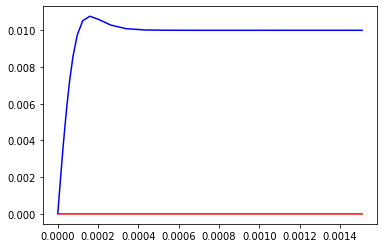

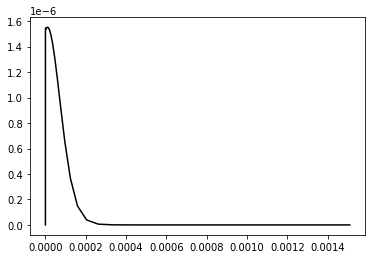

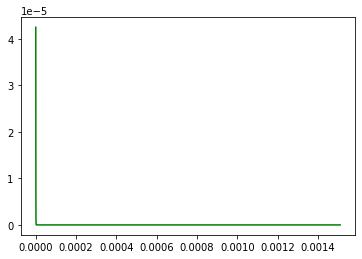

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


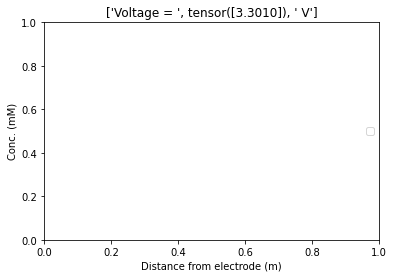

1300 tensor([3.3010])
tensor([3.3020]) tensor([1.4159e-07]) 0.000199285599575361 5.436129762816771e-18 1729345557.5106866 6.2644644643019e-31 86026.26587032306 79000000.0
tensor([3.3030]) tensor([1.4098e-07]) 0.00020320375288097802 5.331310882761838e-18 1763346212.9878135 6.14367372200148e-31 86026.26587032306 79000000.0
tensor([3.3040]) tensor([1.4070e-07]) 0.0002071989409816782 5.228513109283705e-18 1798015355.2042472 6.0252120540391165e-31 86026.26587032306 79000000.0
tensor([3.3050]) tensor([1.4021e-07]) 0.00021127368588727026 5.12767302091017e-18 1833373121.02495 5.9090120103144145e-31 86026.26587032306 79000000.0
tensor([3.3060]) tensor([1.4015e-07]) 0.0002154275369056729 5.028801771180987e-18 1869419061.9754243 5.795075064697544e-31 86026.26587032306 79000000.0
tensor([3.3070]) tensor([1.4010e-07]) 0.00021966305677086366 4.931836946448708e-18 1906173702.0139914 5.683335039234813e-31 86026.26587032306 79000000.0
tensor([3.3080]) tensor([1.3938e-07]) 0.000223982919204924 4.8367187

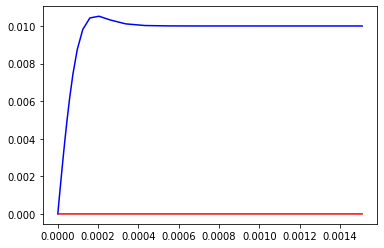

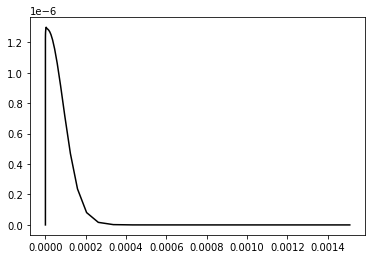

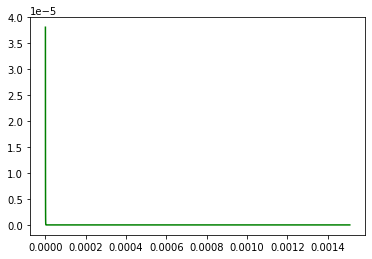

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


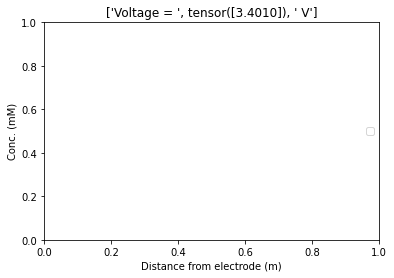

1400 tensor([3.4010])
tensor([3.4020]) tensor([1.1507e-07]) 0.0013967634836175309 7.75609036074322e-19 12120728895.786055 8.937930948435329e-32 86026.26587032306 79000000.0
tensor([3.4030]) tensor([1.1483e-07]) 0.0014242306773863229 7.606509228831535e-19 12359081639.90083 8.765557269683173e-32 86026.26587032306 79000000.0
tensor([3.4040]) tensor([1.1471e-07]) 0.0014522324705337102 7.459841321095553e-19 12602073490.214907 8.59654072001393e-32 86026.26587032306 79000000.0
tensor([3.4050]) tensor([1.1442e-07]) 0.0014807848068142566 7.316001448469043e-19 12849842802.240093 8.430783129607998e-32 86026.26587032306 79000000.0
tensor([3.4060]) tensor([1.1422e-07]) 0.0015098985104541058 7.174935081077652e-19 13102483505.63029 8.26822165955699e-32 86026.26587032306 79000000.0
tensor([3.4070]) tensor([1.1412e-07]) 0.0015395934280935208 7.036548476917757e-19 13360142341.591164 8.108763750067815e-32 86026.26587032306 79000000.0
tensor([3.4080]) tensor([1.1388e-07]) 0.0015698633677803055 6.900870492

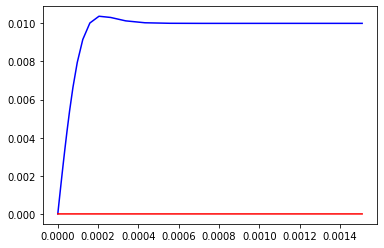

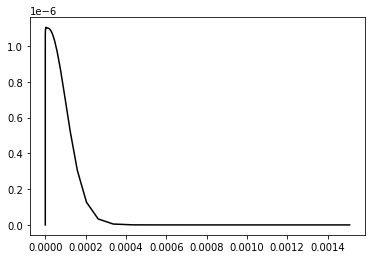

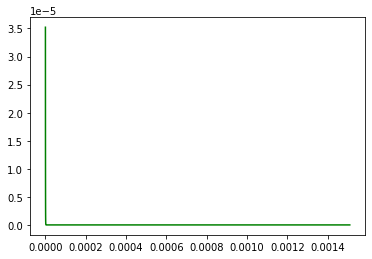

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


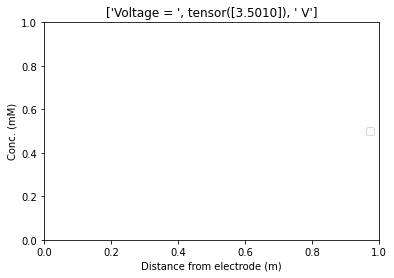

1500 tensor([3.5010])
tensor([3.5020]) tensor([9.9077e-08]) 0.009789747355632112 1.1066091287117337e-19 84952731831.54541 1.2752295962660604e-32 86026.26587032306 79000000.0
tensor([3.5030]) tensor([9.8944e-08]) 0.009982223535769356 1.0852716083450335e-19 86622987122.22482 1.2506407538495667e-32 86026.26587032306 79000000.0
tensor([3.5040]) tensor([9.8817e-08]) 0.010178483989246286 1.0643455157928944e-19 88326081294.90244 1.2265260308960728e-32 86026.26587032306 79000000.0
tensor([3.5050]) tensor([9.8690e-08]) 0.010378642709949015 1.0438189360868049e-19 90063003557.13239 1.2028716968840331e-32 86026.26587032306 79000000.0
tensor([3.5060]) tensor([9.8564e-08]) 0.010582697159083594 1.0236921295839265e-19 91833731877.95984 1.1796780518427436e-32 86026.26587032306 79000000.0
tensor([3.5070]) tensor([9.8433e-08]) 0.010790763521854211 1.0039534060387336e-19 93639274480.59384 1.1569316242159921e-32 86026.26587032306 79000000.0
tensor([3.5080]) tensor([9.8307e-08]) 0.011002920676477398 9.84595

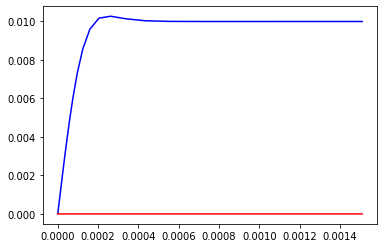

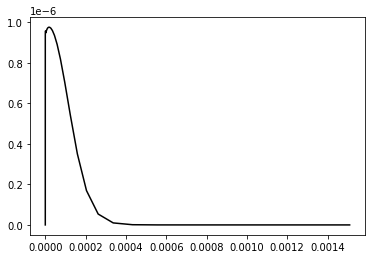

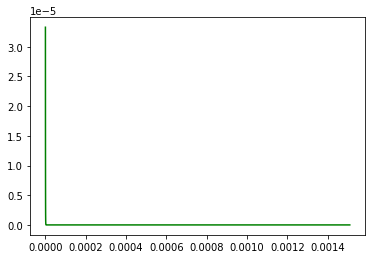

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


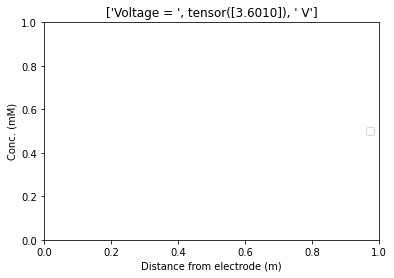

1600 tensor([3.6010])
tensor([3.6020]) tensor([8.8123e-08]) 0.0686147697994115 1.5788763590105308e-20 595421214120.3093 1.8194554602038546e-33 86026.26587032306 79000000.0
tensor([3.6030]) tensor([8.8031e-08]) 0.06996380448970806 1.548432631778578e-20 607127788018.8301 1.7843729121468006e-33 86026.26587032306 79000000.0
tensor([3.6040]) tensor([8.7937e-08]) 0.07133977075345198 1.5185672279441476e-20 619066886364.0569 1.7499601464959e-33 86026.26587032306 79000000.0
tensor([3.6050]) tensor([8.7845e-08]) 0.07274238167564204 1.4892863750090345e-20 631238357721.6152 1.716217599739359e-33 86026.26587032306 79000000.0
tensor([3.6060]) tensor([8.7753e-08]) 0.0741725693250667 1.4605701123882852e-20 643649132324.5431 1.683125673206312e-33 86026.26587032306 79000000.0
tensor([3.6070]) tensor([8.7661e-08]) 0.07563116439708578 1.4324020895203205e-20 656306418718.4321 1.6506655249050364e-33 86026.26587032306 79000000.0
tensor([3.6080]) tensor([8.7569e-08]) 0.0771181483910198 1.404782663685631e-20 6

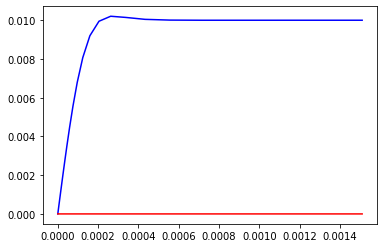

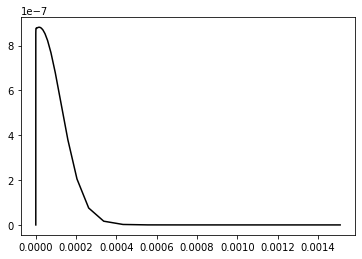

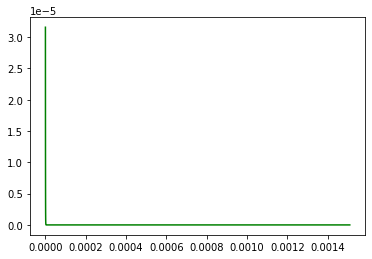

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


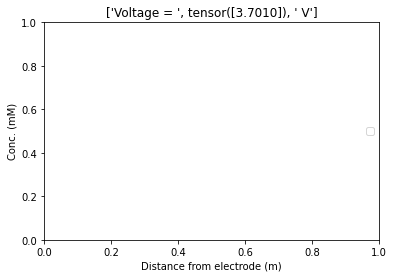

1700 tensor([3.7010])
tensor([3.7020]) tensor([8.0012e-08]) 0.4809108390011844 2.2526886301885524e-21 4173203876705.28 2.595948846879002e-34 86026.26587032306 79000000.0
tensor([3.7030]) tensor([7.9942e-08]) 0.4903678955145367 2.2092440982818995e-21 4255285685085.702 2.545874611778473e-34 86026.26587032306 79000000.0
tensor([3.7040]) tensor([7.9871e-08]) 0.5000090165733223 2.1666456868654127e-21 4338948838413.8384 2.4967853263474656e-34 86026.26587032306 79000000.0
tensor([3.7050]) tensor([7.9801e-08]) 0.50983969167127 2.124868653519651e-21 4424256892635.314 2.448642575334524e-34 86026.26587032306 79000000.0
tensor([3.7060]) tensor([7.9730e-08]) 0.5198666223216817 2.083885236398304e-21 4511259397195.494 2.401418947059184e-34 86026.26587032306 79000000.0
tensor([3.7070]) tensor([7.9660e-08]) 0.5300877177197932 2.0437039813193054e-21 4599955248562.984 2.3551150405014034e-34 86026.26587032306 79000000.0
tensor([3.7080]) tensor([7.9590e-08]) 0.5405097700300274 2.0042974969577733e-21 469039

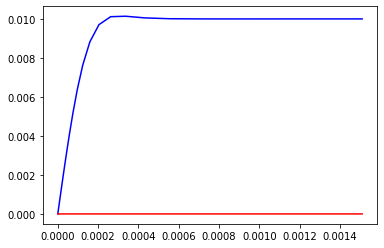

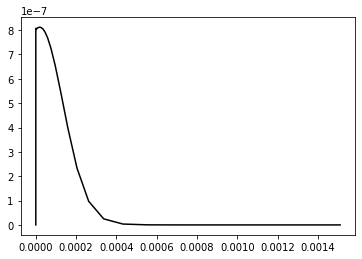

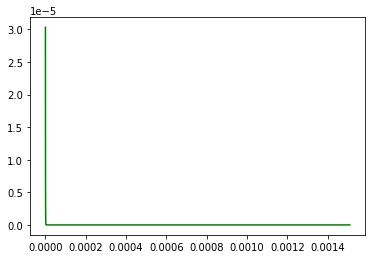

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


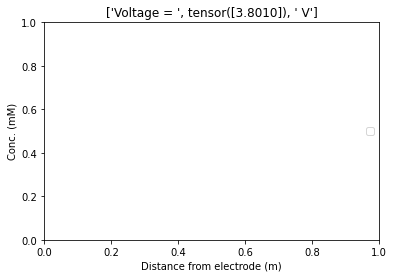

1800 tensor([3.8010])
tensor([3.8020]) tensor([7.3703e-08]) 3.3706462616084782 3.21404945838319e-22 29249484322627.25 3.7037999275574827e-35 86026.26587032306 79000000.0
tensor([3.8030]) tensor([7.3647e-08]) 3.4369165230831045 3.152076496116313e-22 29824558306550.297 3.6323836484595105e-35 86026.26587032306 79000000.0
tensor([3.8040]) tensor([7.3591e-08]) 3.5044897238800607 3.09129848996379e-22 30410938817567.53 3.562344410513856e-35 86026.26587032306 79000000.0
tensor([3.8050]) tensor([7.3535e-08]) 3.573411928252259 3.0316750514745822e-22 31009084732897.938 3.493629007382709e-35 86026.26587032306 79000000.0
tensor([3.8060]) tensor([7.3479e-08]) 3.6436687646159833 2.9732186132637716e-22 31618754212826.5 3.4262652217744096e-35 86026.26587032306 79000000.0
tensor([3.8070]) tensor([7.3423e-08]) 3.715306920333576 2.915889325921796e-22 32240410401745.6 3.3602003375668863e-35 86026.26587032306 79000000.0
tensor([3.8080]) tensor([7.3368e-08]) 3.7883680049683455 2.859654547107436e-22 328744143

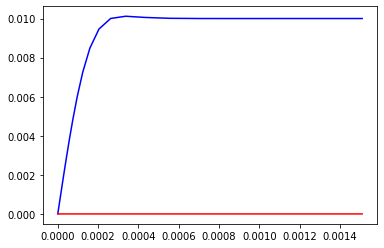

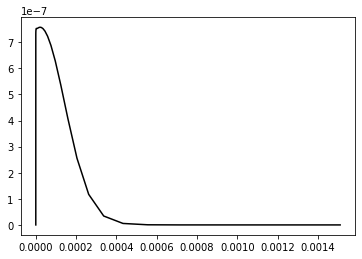

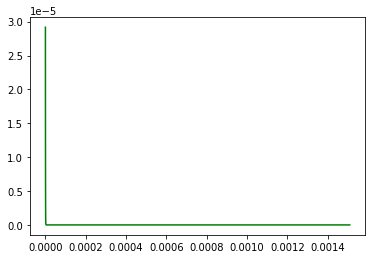

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


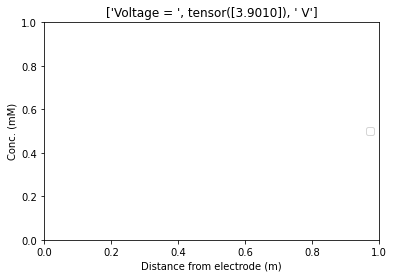

1900 tensor([3.9010])
tensor([3.9020]) tensor([6.8620e-08]) 23.624364351656578 4.585699589739183e-23 205005337583560.75 5.2844593800433705e-36 86026.26587032306 79000000.0
tensor([3.9030]) tensor([6.8574e-08]) 24.0889347681389 4.4972614587560865e-23 209036744043629.78 5.1825452224145435e-36 86026.26587032306 79000000.0
tensor([3.9040]) tensor([6.8529e-08]) 24.56254720973874 4.410545738199635e-23 213146614558183.62 5.0826159326902206e-36 86026.26587032306 79000000.0
tensor([3.9050]) tensor([6.8483e-08]) 25.0454713434909 4.32550206101015e-23 217338118296575.12 4.98459445422316e-36 86026.26587032306 79000000.0
tensor([3.9060]) tensor([6.8437e-08]) 25.537890246534246 4.2420981870239894e-23 221611202094174.28 4.88848203030836e-36 86026.26587032306 79000000.0
tensor([3.9070]) tensor([6.8392e-08]) 26.040139597934154 4.1602786923552075e-23 225969160976010.5 4.7942045475285707e-36 86026.26587032306 79000000.0
tensor([3.9080]) tensor([6.8346e-08]) 26.552114669197593 4.080060637916581e-23 2304119

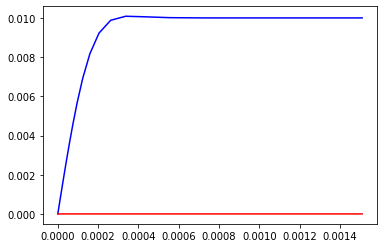

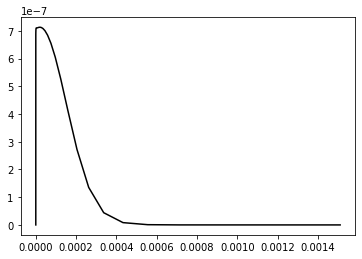

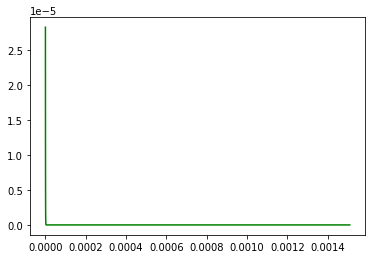

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


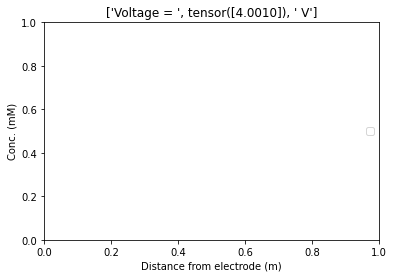

2000 tensor([4.0010])
tensor([4.]) tensor([6.4418e-08]) 159.25557512876458 6.802539743280442e-24 1381976028095252.5 7.839082278768271e-37 86026.26587032306 79000000.0
tensor([3.9990]) tensor([6.4379e-08]) 156.18482594582898 6.936284447556709e-24 1355328912252188.0 7.993206441321945e-37 86026.26587032306 79000000.0
tensor([3.9980]) tensor([6.4341e-08]) 153.1724101623121 7.07269917607499e-24 1329190532813827.5 8.150391929583081e-37 86026.26587032306 79000000.0
tensor([3.9970]) tensor([6.4303e-08]) 150.21895592390388 7.211755483783232e-24 1303561221316860.8 8.310636749826068e-37 86026.26587032306 79000000.0
tensor([3.9960]) tensor([6.4265e-08]) 147.32244987824865 7.353545776951913e-24 1278426091497833.8 8.474032142782194e-37 86026.26587032306 79000000.0
tensor([3.9950]) tensor([6.4226e-08]) 144.48124280305424 7.498152411584212e-24 1253766049085489.8 8.640705974951286e-37 86026.26587032306 79000000.0
tensor([3.9940]) tensor([6.4188e-08]) 141.6953707359177 7.645573553503496e-24 122959106451

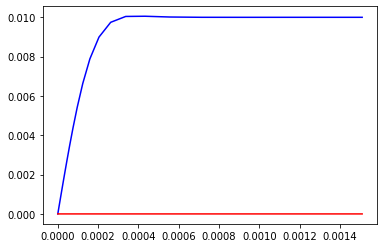

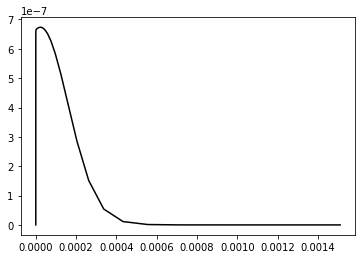

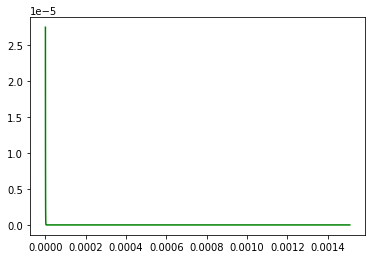

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


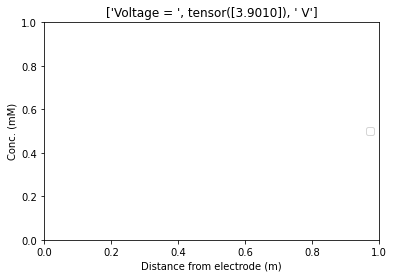

2100 tensor([3.9010])
tensor([3.9000]) tensor([6.0872e-08]) 22.72205935185036 4.7678001468831837e-23 197175774272426.47 5.494297578644794e-36 86026.26587032306 79000000.0
tensor([3.8990]) tensor([6.0839e-08]) 22.283849996475 4.8615583901515005e-23 193373114152514.44 5.602342310617014e-36 86026.26587032306 79000000.0
tensor([3.8980]) tensor([6.0806e-08]) 21.85417515392078 4.957141468494394e-23 189644514184786.9 5.7124899383950116e-36 86026.26587032306 79000000.0
tensor([3.8970]) tensor([6.0774e-08]) 21.43278525630889 5.0546038053244444e-23 185987808687913.12 5.824803178203201e-36 86026.26587032306 79000000.0
tensor([3.8960]) tensor([6.0741e-08]) 21.019400279888536 5.15401184014252e-23 182400915594696.75 5.939347264898835e-36 86026.26587032306 79000000.0
tensor([3.8950]) tensor([6.0709e-08]) 20.614106423249133 5.2553448444924254e-23 178883880400944.53 6.056120745615741e-36 86026.26587032306 79000000.0
tensor([3.8940]) tensor([6.0676e-08]) 20.21662739995618 5.35867015659968e-23 1754339910

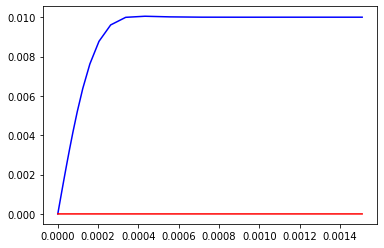

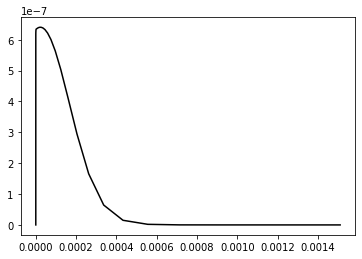

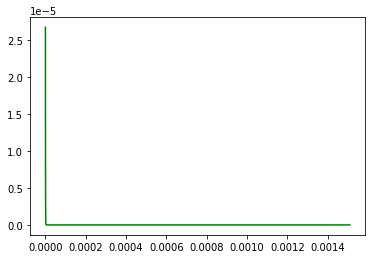

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


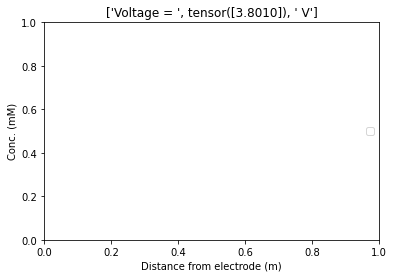

2200 tensor([3.8010])
tensor([3.8000]) tensor([5.7830e-08]) 3.2418959981634337 3.3416938105544707e-22 28132280778348.605 3.8508871274531583e-35 86026.26587032306 79000000.0
tensor([3.7990]) tensor([5.7801e-08]) 3.1793861018569873 3.407394838014975e-22 27589837111027.188 3.9265994025003214e-35 86026.26587032306 79000000.0
tensor([3.7980]) tensor([5.7773e-08]) 3.118081514770349 3.4743876130903364e-22 27057852785219.367 4.0038002562575567e-35 86026.26587032306 79000000.0
tensor([3.7970]) tensor([5.7745e-08]) 3.057947331092845 3.542711047169155e-22 26536024897911.85 4.0825345292680026e-35 86026.26587032306 79000000.0
tensor([3.7960]) tensor([5.7717e-08]) 2.9989843135606735 3.6123642736435665e-22 26024360067919.324 4.1628012228737183e-35 86026.26587032306 79000000.0
tensor([3.7950]) tensor([5.7689e-08]) 2.941158214706319 3.6833869519004416e-22 25522561105149.133 4.244646039592958e-35 86026.26587032306 79000000.0
tensor([3.7940]) tensor([5.7661e-08]) 2.8844306076923405 3.7558274976811546e-22

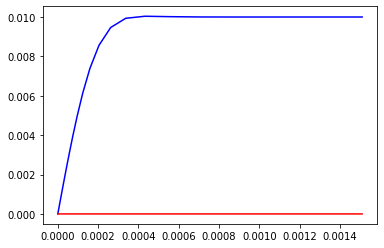

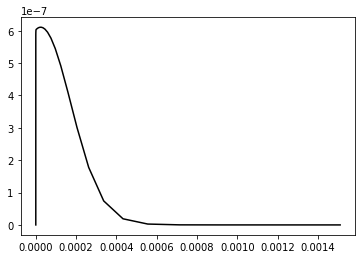

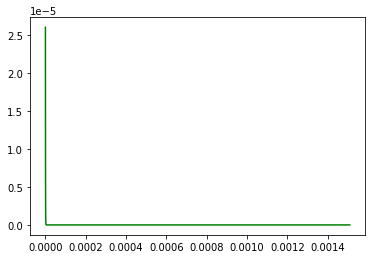

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


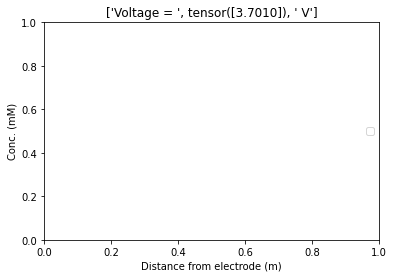

2300 tensor([3.7010])
tensor([3.7000]) tensor([5.5185e-08]) 0.4625438935091642 2.342139620379491e-21 4013820885276.4995 2.699030201188903e-34 86026.26587032306 79000000.0
tensor([3.6990]) tensor([5.5160e-08]) 0.45362257534052447 2.388202082621581e-21 3936411798560.6904 2.7521063206560828e-34 86026.26587032306 79000000.0
tensor([3.6980]) tensor([5.5135e-08]) 0.44487587274338286 2.4351565133704346e-21 3860510321928.838 2.8062154710445948e-34 86026.26587032306 79000000.0
tensor([3.6970]) tensor([5.5111e-08]) 0.4362978231421054 2.4830341149778155e-21 3786072369554.534 2.861388461203319e-34 86026.26587032306 79000000.0
tensor([3.6960]) tensor([5.5086e-08]) 0.4278851745874352 2.5318530379019533e-21 3713069721917.5874 2.917646207281347e-34 86026.26587032306 79000000.0
tensor([3.6950]) tensor([5.5061e-08]) 0.41963233667149624 2.5816465617150142e-21 3641460812526.514 2.9750213854443816e-34 86026.26587032306 79000000.0
tensor([3.6940]) tensor([5.5037e-08]) 0.4115410302671492 2.6324043035251203e-

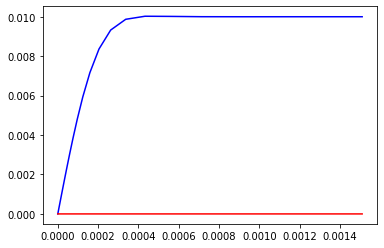

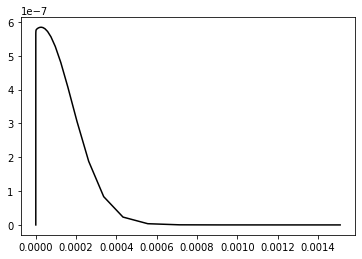

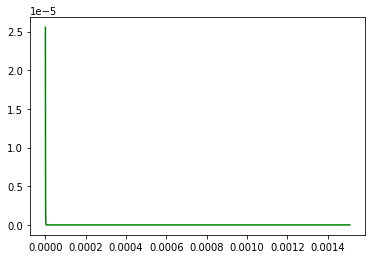

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


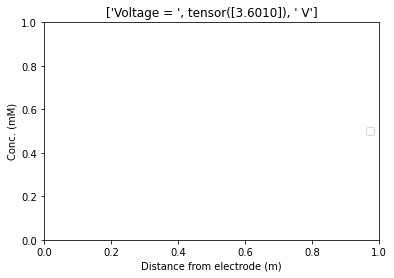

2400 tensor([3.6010])
tensor([3.6000]) tensor([5.2858e-08]) 0.06599398294504412 1.6415775057167695e-20 572676519492.6328 1.8917178237239423e-33 86026.26587032306 79000000.0
tensor([3.5990]) tensor([5.2837e-08]) 0.06472149393457584 1.673852553909694e-20 561634231315.93 1.9289108796201644e-33 86026.26587032306 79000000.0
tensor([3.5980]) tensor([5.2814e-08]) 0.06347341985678205 1.7067654170782038e-20 550804859373.8325 1.966835188026434e-33 86026.26587032306 79000000.0
tensor([3.5970]) tensor([5.2792e-08]) 0.06224929461495425 1.7403287633273074e-20 540182237602.35284 2.0055127765046804e-33 86026.26587032306 79000000.0
tensor([3.5960]) tensor([5.2771e-08]) 0.06104901028944394 1.774545359566177e-20 529766500737.80316 2.0449431544720927e-33 86026.26587032306 79000000.0
tensor([3.5950]) tensor([5.2749e-08]) 0.05987186971955331 1.8094346881547303e-20 519551599011.61914 2.0851487729290536e-33 86026.26587032306 79000000.0
tensor([3.5940]) tensor([5.2727e-08]) 0.05871742664983035 1.84500997568076

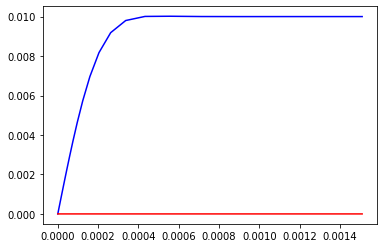

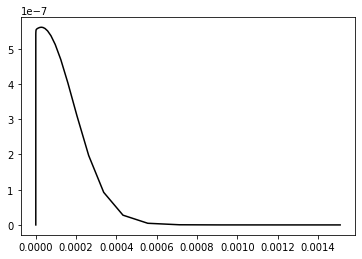

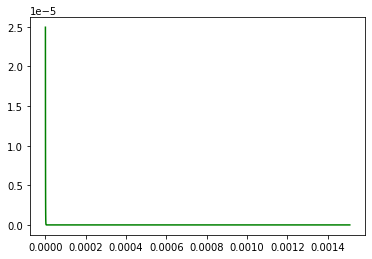

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


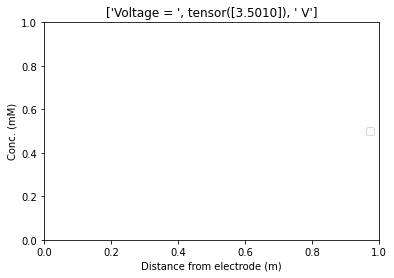

2500 tensor([3.5010])
tensor([3.5000]) tensor([5.0787e-08]) 0.009415803472687662 1.1505575517743618e-19 81707593940.12831 1.3258772250058307e-32 86026.26587032306 79000000.0
tensor([3.4990]) tensor([5.0768e-08]) 0.009234248944395264 1.1731786587905894e-19 80132116741.74191 1.351945291354169e-32 86026.26587032306 79000000.0
tensor([3.4980]) tensor([5.0751e-08]) 0.00905614331153008 1.1962513642790058e-19 78586717943.2214 1.3785311405104308e-32 86026.26587032306 79000000.0
tensor([3.4970]) tensor([5.0725e-08]) 0.00888152371248657 1.219770857143949e-19 77071417146.25642 1.4056344352622646e-32 86026.26587032306 79000000.0
tensor([3.4960]) tensor([5.0704e-08]) 0.008710271110112747 1.2437527666557127e-19 75585334219.24931 1.4332706077742136e-32 86026.26587032306 79000000.0
tensor([3.4950]) tensor([5.0690e-08]) 0.00854228799602955 1.2682110222178676e-19 74127623011.3367 1.4614557099540675e-32 86026.26587032306 79000000.0
tensor([3.4940]) tensor([5.0670e-08]) 0.008377576500918632 1.293145313604

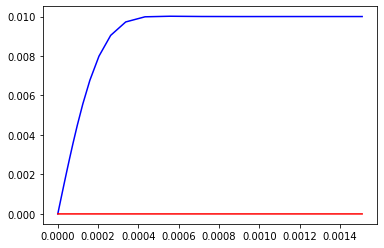

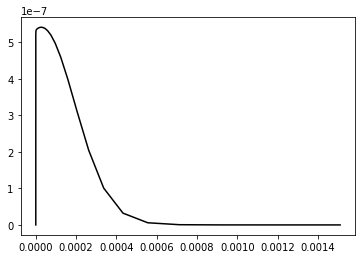

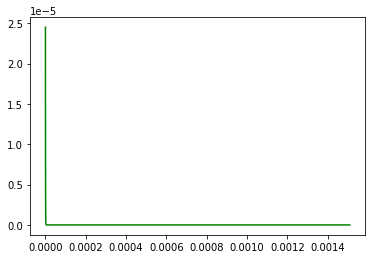

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


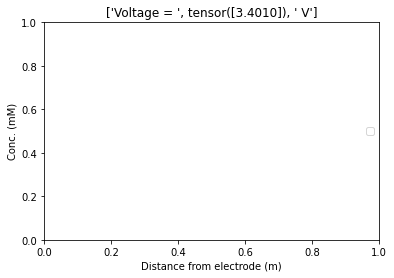

2600 tensor([3.4010])
tensor([3.4000]) tensor([4.8885e-08]) 0.0013434157339784398 8.064088812955588e-19 11657814049.834936 9.292843191024692e-32 86026.26587032306 79000000.0
tensor([3.3990]) tensor([4.8882e-08]) 0.0013175071077543884 8.222668194928353e-19 11432942083.58201 9.475622033528113e-32 86026.26587032306 79000000.0
tensor([3.3980]) tensor([4.8854e-08]) 0.0012921030748256983 8.384334038509627e-19 11212493301.595427 9.661922197075082e-32 86026.26587032306 79000000.0
tensor([3.3970]) tensor([4.8847e-08]) 0.001267188879777384 8.549178393537701e-19 10996295189.744675 9.851885207326449e-32 86026.26587032306 79000000.0
tensor([3.3960]) tensor([4.8819e-08]) 0.0012427479665259105 8.717313633438308e-19 10784224648.4263 1.0045621400426718e-31 86026.26587032306 79000000.0
tensor([3.3950]) tensor([4.8781e-08]) 0.0012187854314641474 8.888704698832575e-19 10576284367.522644 1.024312831904466e-31 86026.26587032306 79000000.0
tensor([3.3940]) tensor([4.8768e-08]) 0.0011952849394731054 9.0634654

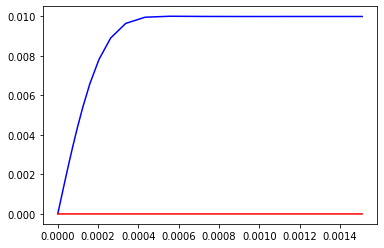

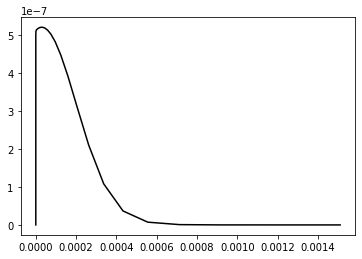

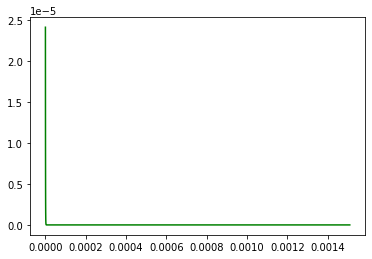

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


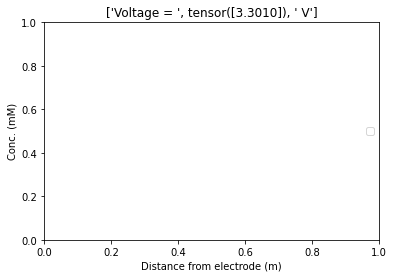

2700 tensor([3.3010])
tensor([3.3000]) tensor([4.7003e-08]) 0.00019167357051013217 5.652017522651295e-18 1663292051.5813916 6.513242085912734e-31 86026.26587032306 79000000.0
tensor([3.2990]) tensor([4.7003e-08]) 0.0001879775616939945 5.763147310719777e-18 1631220629.879218 6.641298910207017e-31 86026.26587032306 79000000.0
tensor([3.2980]) tensor([4.6864e-08]) 0.00018435299819902524 5.8764565249046954e-18 1599767605.943703 6.771873459166226e-31 86026.26587032306 79000000.0
tensor([3.2970]) tensor([4.6837e-08]) 0.00018079746104309702 5.992022083176086e-18 1568909086.0223475 6.905067915050461e-31 86026.26587032306 79000000.0
tensor([3.2960]) tensor([4.6892e-08]) 0.00017731134349069092 6.1098312032658094e-18 1538657546.695652 7.040828425265519e-31 86026.26587032306 79000000.0
tensor([3.2950]) tensor([4.6671e-08]) 0.00017389244488881143 6.22995656795271e-18 1508989314.3558228 7.179258122280852e-31 86026.26587032306 79000000.0
tensor([3.2940]) tensor([4.6864e-08]) 0.00017053865593513314 6.

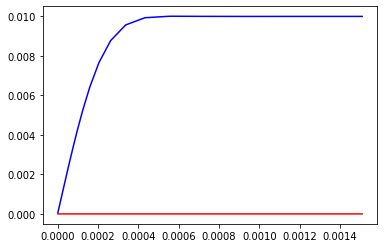

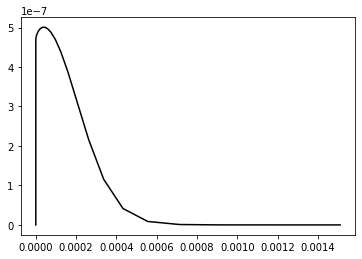

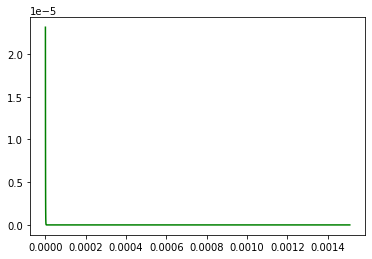

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


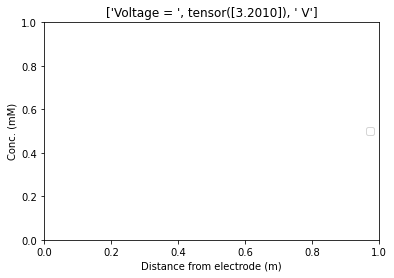

2800 tensor([3.2010])
tensor([3.2000]) tensor([4.3659e-08]) 2.7347351838646323e-05 3.9614160286681354e-17 237313015.16405824 4.5650356698871894e-30 86026.26587032306 79000000.0
tensor([3.1990]) tensor([4.3659e-08]) 2.681991520062878e-05 4.0393206728968593e-17 232736282.84473372 4.654806572961982e-30 86026.26587032306 79000000.0
tensor([3.1980]) tensor([4.3438e-08]) 2.630277642779685e-05 4.1187377390606034e-17 228248686.4148625 4.7463247047272515e-30 86026.26587032306 79000000.0
tensor([3.1970]) tensor([4.3770e-08]) 2.579560907017506e-05 4.1997162238164337e-17 223846765.4362087 4.839660635887694e-30 86026.26587032306 79000000.0
tensor([3.1960]) tensor([4.3438e-08]) 2.529822085998826e-05 4.2822868262084895e-17 219530575.74231425 4.934813182579344e-30 86026.26587032306 79000000.0
tensor([3.1950]) tensor([4.3106e-08]) 2.4810304931713212e-05 4.366501669907521e-17 215296789.0686875 5.031855718046866e-30 86026.26587032306 79000000.0
tensor([3.1940]) tensor([4.3327e-08]) 2.4331915251880393e-05

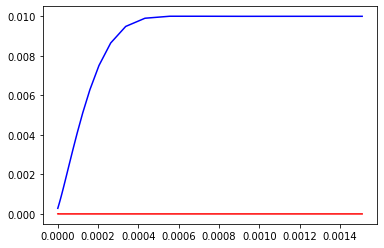

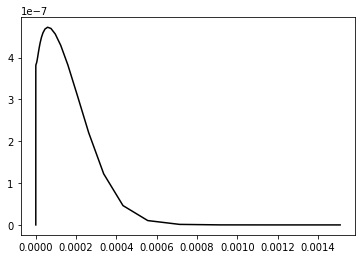

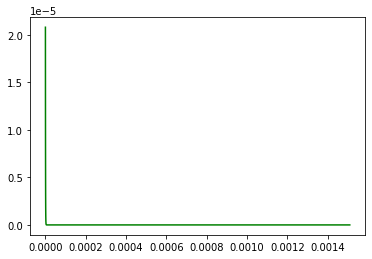

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


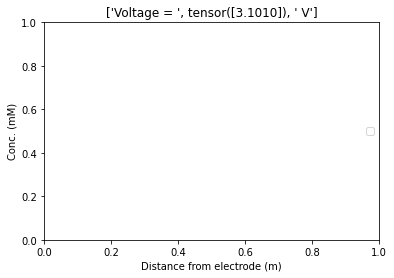

2900 tensor([3.1010])
tensor([3.1000]) tensor([3.4485e-08]) 3.901814932934552e-06 2.7765088754161495e-16 33858907.86830497 3.1995786260032114e-29 86026.26587032306 79000000.0
tensor([3.0990]) tensor([3.3601e-08]) 3.826580549412424e-06 2.8310978043275575e-16 33206043.982141975 3.262485527438984e-29 86026.26587032306 79000000.0
tensor([3.0980]) tensor([3.1832e-08]) 3.7527968273289456e-06 2.8867600059326276e-16 32565768.548492383 3.326629241190005e-29 86026.26587032306 79000000.0
tensor([3.0970]) tensor([3.2717e-08]) 3.6804182455398263e-06 2.9435306176554016e-16 31937595.172700655 3.392059963482835e-29 86026.26587032306 79000000.0
tensor([3.0960]) tensor([3.4485e-08]) 3.609452809565514e-06 3.0014033603138093e-16 31321777.83505202 3.458751239656783e-29 86026.26587032306 79000000.0
tensor([3.0950]) tensor([3.4485e-08]) 3.539855721634017e-06 3.0604139387136624e-16 30717834.622280292 3.526753732721233e-29 86026.26587032306 79000000.0
tensor([3.0940]) tensor([3.4485e-08]) 3.471600597402864e-06

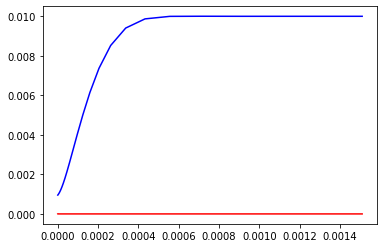

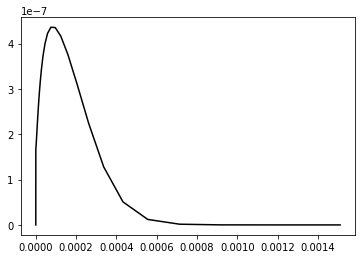

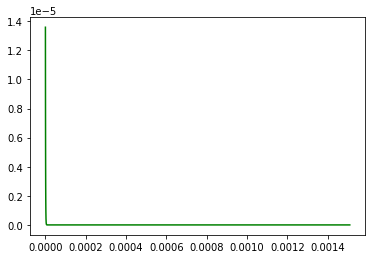

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


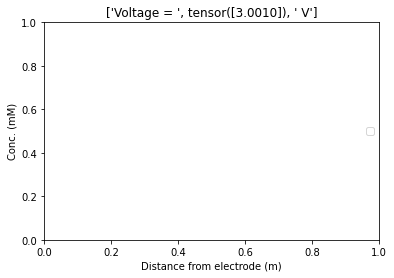

3000 tensor([3.0010])
tensor([3.]) tensor([1.5916e-08]) 5.566985957294997e-07 1.9460124158078573e-15 4830877.120316904 2.242537643104734e-28 86026.26587032306 79000000.0
tensor([2.9990]) tensor([1.4148e-08]) 5.459643921915981e-07 1.9842729574426578e-15 4737728.657802602 2.2866281659424295e-28 86026.26587032306 79000000.0
tensor([2.9980]) tensor([1.0611e-08]) 5.354346112755574e-07 2.023295387221189e-15 4646358.549621368 2.331594446667675e-28 86026.26587032306 79000000.0
tensor([2.9970]) tensor([1.0611e-08]) 5.251104176405122e-07 2.063075389020478e-15 4556767.954702857 2.3774359149324933e-28 86026.26587032306 79000000.0
tensor([2.9960]) tensor([1.7685e-08]) 5.14985294016948e-07 2.1036375052619524e-15 4468904.8361751875 2.424178672105285e-28 86026.26587032306 79000000.0
tensor([2.9950]) tensor([1.7685e-08]) 5.050529936718401e-07 2.145007341261917e-15 4382702.447527367 2.471859297141209e-28 86026.26587032306 79000000.0
tensor([2.9940]) tensor([1.4148e-08]) 4.953141428106611e-07 2.187182407

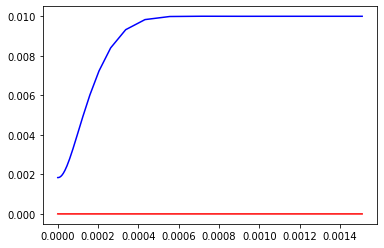

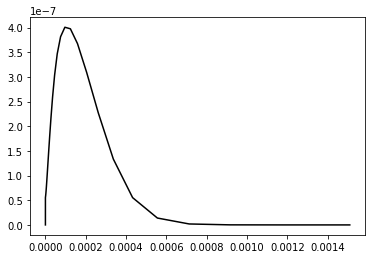

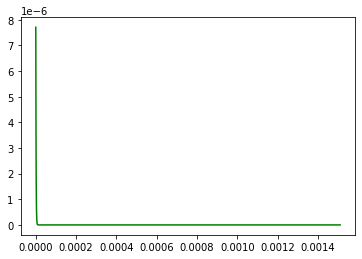

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


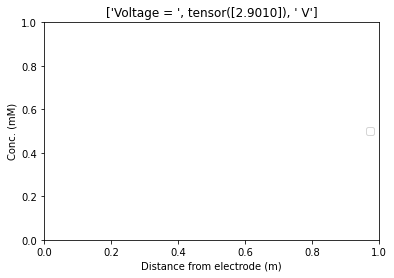

3100 tensor([2.9010])
tensor([2.9000]) tensor([7.0739e-09]) 7.94279544355418e-08 1.3639308563983865e-14 689253.5885201205 1.5717616813260607e-27 86026.26587032306 79000000.0
tensor([2.8990]) tensor([3.5369e-09]) 7.789606156711089e-08 1.3907537266425953e-14 675960.8950173656 1.6026701945895465e-27 86026.26587032306 79000000.0
tensor([2.8980]) tensor([3.5369e-09]) 7.639407793345975e-08 1.4180973296071601e-14 662927.0884181764 1.6341802863077904e-27 86026.26587032306 79000000.0
tensor([2.8970]) tensor([7.0739e-09]) 7.492105538962973e-08 1.445978535030564e-14 650144.5983015193 1.6663098978021207e-27 86026.26587032306 79000000.0
tensor([2.8960]) tensor([3.5369e-09]) 7.347608514883333e-08 1.4744149432539644e-14 637606.1465304533 1.6990776909028167e-27 86026.26587032306 79000000.0
tensor([2.8950]) tensor([7.0739e-09]) 7.205932703374908e-08 1.503403409034087e-14 625311.8921414939 1.7324832499863443e-27 86026.26587032306 79000000.0
tensor([2.8940]) tensor([7.0739e-09]) 7.066985300101647e-08 1.5

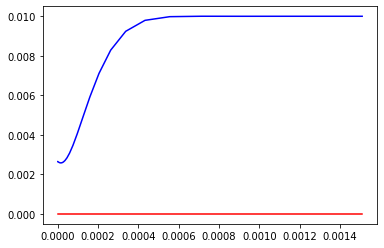

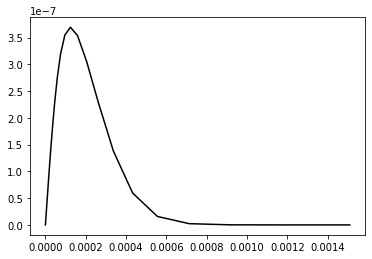

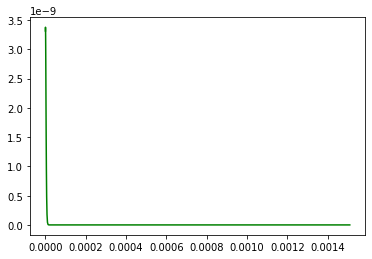

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


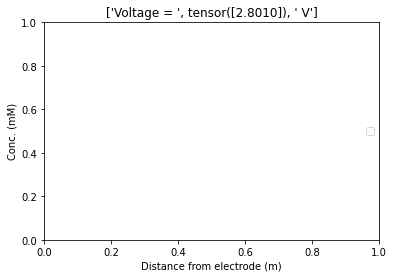

3200 tensor([2.8010])
tensor([2.8000]) tensor([0.]) 1.1332474915215876e-08 9.559627418171685e-14 98340.04989346181 1.1016288687325876e-26 86026.26587032306 79000000.0
tensor([2.7990]) tensor([0.]) 1.111396333056083e-08 9.747579211220396e-14 96443.86743569835 1.1232879891245528e-26 86026.26587032306 79000000.0
tensor([2.7980]) tensor([0.]) 1.089966506320723e-08 9.939226323653946e-14 94584.24696785689 1.1453729493882464e-26 86026.26587032306 79000000.0
tensor([2.7970]) tensor([7.0739e-09]) 1.0689447901034649e-08 1.013468973498198e-13 92760.12965302062 1.1678965771229145e-26 86026.26587032306 79000000.0
tensor([2.7960]) tensor([0.]) 1.0483330096523662e-08 1.0333952753349325e-13 90971.53862811803 1.1908585866410307e-26 86026.26587032306 79000000.0
tensor([2.7950]) tensor([0.]) 1.0281191632596633e-08 1.0537128553441764e-13 89217.43502649013 1.2142720521283123e-26 86026.26587032306 79000000.0
tensor([2.7940]) tensor([0.]) 1.0082902702044764e-08 1.0744350224987381e-13 87496.48631752242 1.2381

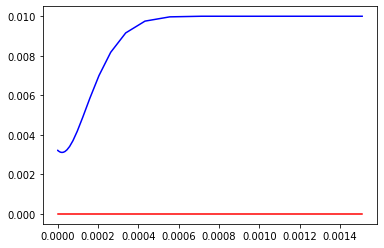

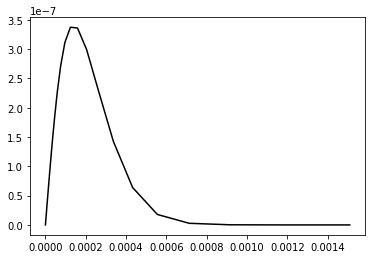

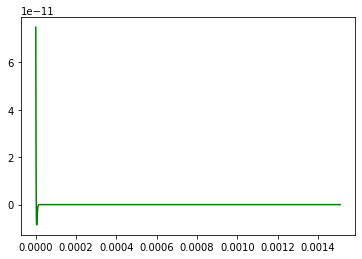

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


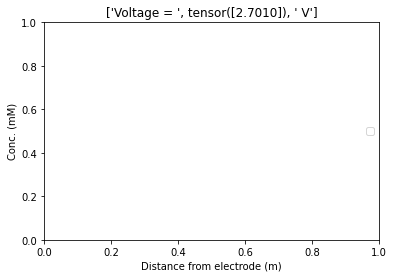

3300 tensor([2.7010])
tensor([2.7000]) tensor([0.]) 1.6168812400764357e-09 6.70019759213232e-13 14030.833448288953 7.721154863288025e-26 86026.26587032306 79000000.0
tensor([2.6990]) tensor([-7.0739e-09]) 1.5856971455296866e-09 6.831962725079671e-13 13760.23990808447 7.872990488457371e-26 86026.26587032306 79000000.0
tensor([2.6980]) tensor([-7.0739e-09]) 1.555121900612317e-09 6.966285914472992e-13 13494.916415198373 8.027781320174117e-26 86026.26587032306 79000000.0
tensor([2.6970]) tensor([0.]) 1.5251358407180675e-09 7.103251725055154e-13 13234.7088618851 8.185615493759328e-26 86026.26587032306 79000000.0
tensor([2.6960]) tensor([0.]) 1.4957283324850648e-09 7.242908726295876e-13 12979.518603138024 8.346552844344233e-26 86026.26587032306 79000000.0
tensor([2.6950]) tensor([-7.0739e-09]) 1.4668808620708118e-09 7.385346739223518e-13 12729.200337874787 8.510686849110238e-26 86026.26587032306 79000000.0
tensor([2.6940]) tensor([0.]) 1.4385962771964915e-09 7.53055180473289e-13 12483.757241

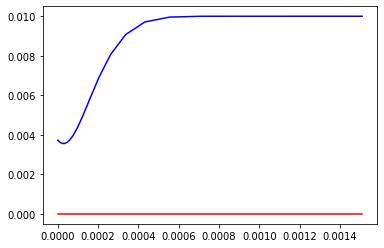

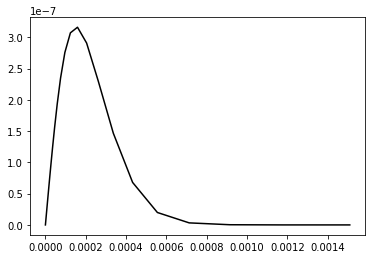

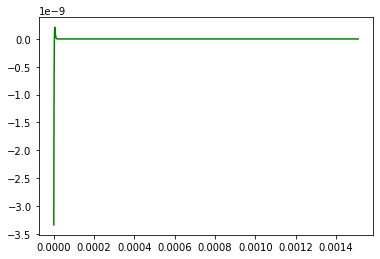

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


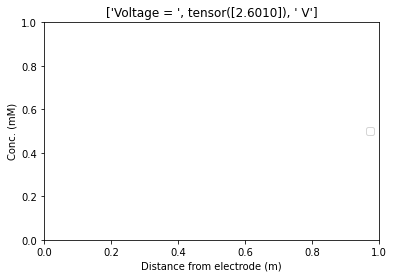

3400 tensor([2.6010])
tensor([2.6000]) tensor([-7.0739e-09]) 2.3069039388291477e-10 4.6960879511187966e-12 2001.869146684678 5.411654307907902e-25 86026.26587032306 79000000.0
tensor([2.5990]) tensor([0.]) 2.262422190977926e-10 4.788418286704188e-12 1963.2655725515174 5.518063344555377e-25 86026.26587032306 79000000.0
tensor([2.5980]) tensor([0.]) 2.218798140692084e-10 4.882563939838578e-12 1925.4100930938994 5.626553963948564e-25 86026.26587032306 79000000.0
tensor([2.5970]) tensor([0.]) 2.1760051332129311e-10 4.9785837478830785e-12 1888.27733577368 5.737199502574815e-25 86026.26587032306 79000000.0
tensor([2.5960]) tensor([0.]) 2.1340473776127267e-10 5.0764682664369765e-12 1851.86777157918 5.849998557016764e-25 86026.26587032306 79000000.0
tensor([2.5950]) tensor([-7.0739e-09]) 2.0928986519307592e-10 5.176277303982163e-12 1816.1602527567863 5.965015353177001e-25 86026.26587032306 79000000.0
tensor([2.5940]) tensor([0.]) 2.052543356442991e-10 5.27804869871208e-12 1781.1412425417673 6.

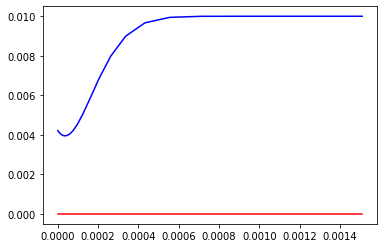

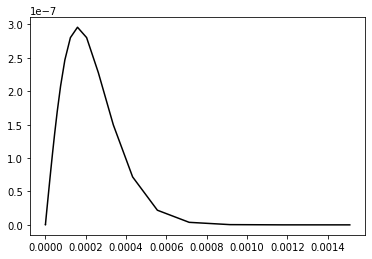

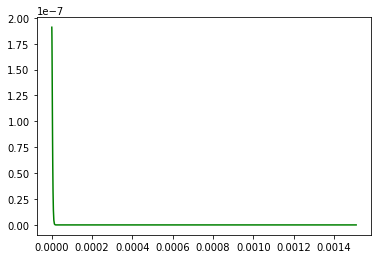

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


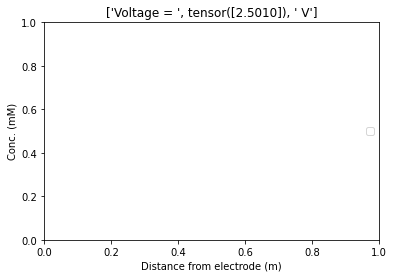

3500 tensor([2.5010])
tensor([2.5000]) tensor([0.]) 3.291416684578854e-11 3.291416684578854e-11 285.6200765896549 3.792948983445668e-24 86026.26587032306 79000000.0
tensor([2.4990]) tensor([0.]) 3.227951526774168e-11 3.356129638771362e-11 280.11278043309323 3.867522136895745e-24 86026.26587032306 79000000.0
tensor([2.4980]) tensor([0.]) 3.1656954110445494e-11 3.422130806939973e-11 274.7101034711576 3.9435840380954446e-24 86026.26587032306 79000000.0
tensor([2.4970]) tensor([0.]) 3.104654413177329e-11 3.489413747804877e-11 269.4131722642209 4.02111882669917e-24 86026.26587032306 79000000.0
tensor([2.4960]) tensor([0.]) 3.044790408967688e-11 3.558019546966795e-11 264.2183759254835 4.100178026444068e-24 86026.26587032306 79000000.0
tensor([2.4950]) tensor([0.]) 2.9860668431083954e-11 3.6279910533572734e-11 259.12275662444506 4.1808075572556844e-24 86026.26587032306 79000000.0
tensor([2.4940]) tensor([0.]) 2.9284894466331564e-11 3.6993214382176074e-11 254.12637899345052 4.263006396436813e-

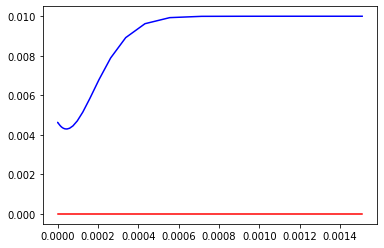

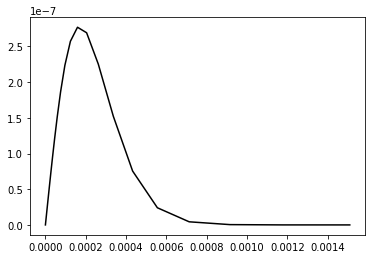

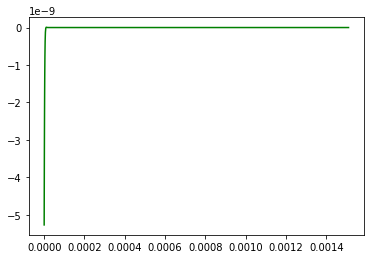

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


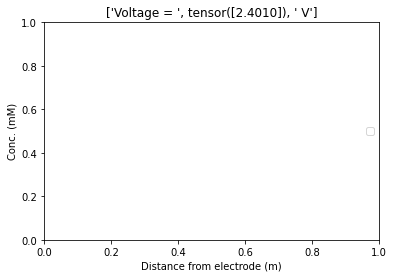

3600 tensor([2.4010])
tensor([2.4000]) tensor([1.4148e-08]) 4.6960879511187966e-12 2.3069039388291477e-10 40.7513289698201 2.658422207419823e-23 86026.26587032306 79000000.0
tensor([2.3990]) tensor([1.4148e-08]) 4.6055165182653765e-12 2.352271183603171e-10 39.96541369154232 2.71069977534517e-23 86026.26587032306 79000000.0
tensor([2.3980]) tensor([0.]) 4.516712896648563e-12 2.3985194630286415e-10 39.19480480491616 2.7639948318265973e-23 86026.26587032306 79000000.0
tensor([2.3970]) tensor([0.]) 4.4296215874685845e-12 2.445677035296165e-10 38.43905471746897 2.818337722181474e-23 86026.26587032306 79000000.0
tensor([2.3960]) tensor([0.]) 4.344189377009262e-12 2.493773372049052e-10 37.69766121503913 2.873765491638022e-23 86026.26587032306 79000000.0
tensor([2.3950]) tensor([-1.4148e-08]) 4.260424160404909e-12 2.542804045711367e-10 36.9707788922001 2.93026658245754e-23 86026.26587032306 79000000.0
tensor([2.3940]) tensor([-1.4148e-08]) 4.1782751116262746e-12 2.5927981049834353e-10 36.25791

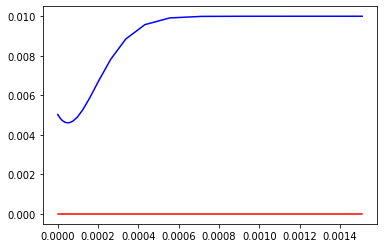

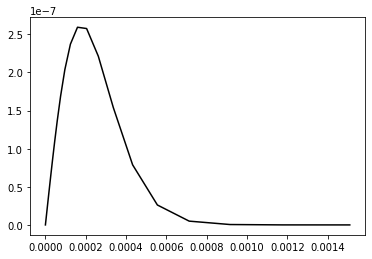

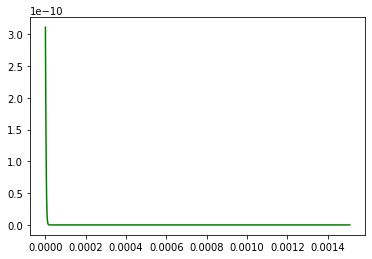

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


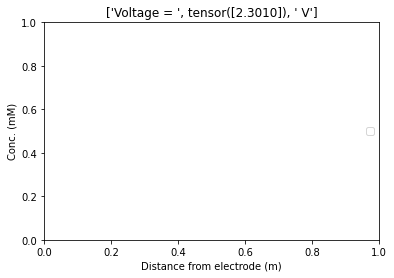

3700 tensor([2.3010])
tensor([2.3000]) tensor([0.]) 6.70019759213232e-13 1.6168812400764357e-09 5.814242814058266 1.8632561690285627e-22 86026.26587032306 79000000.0
tensor([2.2990]) tensor([-1.4148e-08]) 6.571003523023089e-13 1.6486711281719074e-09 5.702133198076391 1.8998896404557328e-22 86026.26587032306 79000000.0
tensor([2.2980]) tensor([-1.4148e-08]) 6.444300590520427e-13 1.6810860448471371e-09 5.59218526787159 1.9372433624051414e-22 86026.26587032306 79000000.0
tensor([2.2970]) tensor([0.]) 6.320012130786081e-13 1.7141460439216904e-09 5.484336420923921 1.9753390310251963e-22 86026.26587032306 79000000.0
tensor([2.2960]) tensor([-1.4148e-08]) 6.198150324246103e-13 1.7478478618283189e-09 5.3785880251777805 2.0141761631141054e-22 86026.26587032306 79000000.0
tensor([2.2950]) tensor([0.]) 6.078636794931633e-13 1.782212715942654e-09 5.274868597808841 2.053780789160172e-22 86026.26587032306 79000000.0
tensor([2.2940]) tensor([1.4148e-08]) 5.961400735887783e-13 1.8172614577487753e-09 5

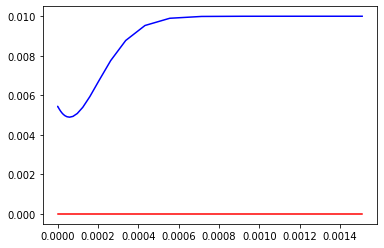

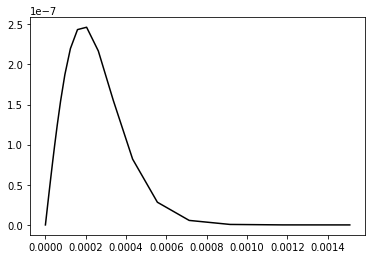

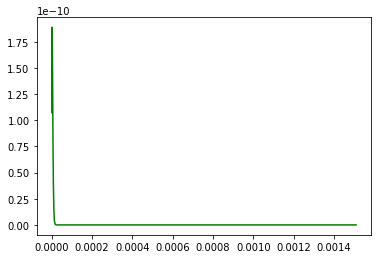

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


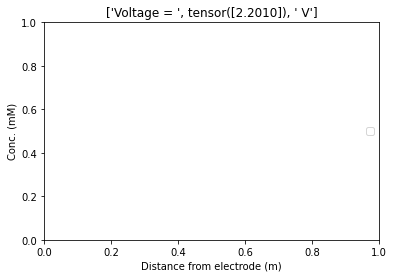

3800 tensor([2.2010])
tensor([2.2000]) tensor([0.]) 9.559627418171685e-14 1.1332474915215876e-08 0.8295585393688537 1.305926378597267e-21 86026.26587032306 79000000.0
tensor([2.1990]) tensor([0.]) 9.37525498694361e-14 1.155533775519829e-08 0.8135584239785616 1.3316098109518846e-21 86026.26587032306 79000000.0
tensor([2.1980]) tensor([0.]) 9.194477926001812e-14 1.1782532818842637e-08 0.7978714763556443 1.35779058564755e-21 86026.26587032306 79000000.0
tensor([2.1970]) tensor([0.]) 9.017190973529595e-14 1.2014189145296025e-08 0.7824870028003184 1.3844861004405235e-21 86026.26587032306 79000000.0
tensor([2.1960]) tensor([0.]) 8.843322449354212e-14 1.2250400065775247e-08 0.7673991710395526 1.4117064756336161e-21 86026.26587032306 79000000.0
tensor([2.1950]) tensor([0.]) 8.672765084637053e-14 1.2491314691221597e-08 0.7525979548452272 1.4394702671962434e-21 86026.26587032306 79000000.0
tensor([2.1940]) tensor([0.]) 8.505537744081417e-14 1.2736906374981992e-08 0.7380864405509777 1.46777168585

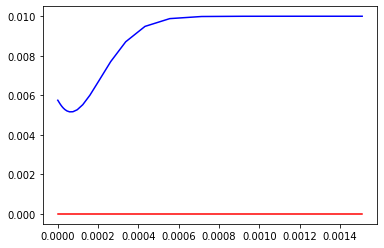

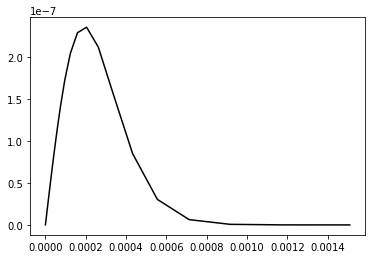

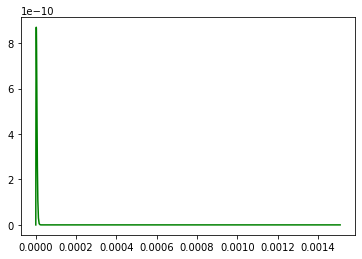

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


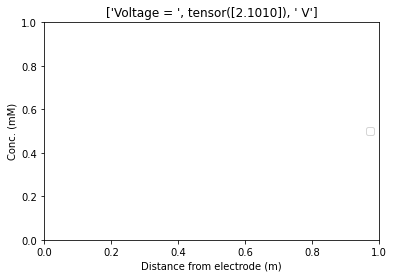

3900 tensor([2.1010])
tensor([2.1000]) tensor([-1.4148e-08]) 1.3639308563983865e-14 7.94279544355418e-08 0.11835822041381935 9.153081005820156e-21 86026.26587032306 79000000.0
tensor([2.0990]) tensor([0.]) 1.3376310478181493e-14 8.098962572074549e-08 0.1160758283086307 9.333057493003085e-21 86026.26587032306 79000000.0
tensor([2.0980]) tensor([0.]) 1.3118389872021508e-14 8.25819623994347e-08 0.11383766644428717 9.51655469573948e-21 86026.26587032306 79000000.0
tensor([2.0970]) tensor([0.]) 1.2865381116690231e-14 8.420600752720708e-08 0.11164223469853199 9.703696652774458e-21 86026.26587032306 79000000.0
tensor([2.0960]) tensor([0.]) 1.2617312196526597e-14 8.586158147458993e-08 0.10948956091801015 9.894480990417456e-21 86026.26587032306 79000000.0
tensor([2.0950]) tensor([-1.4148e-08]) 1.2374020614692323e-14 8.754974740110714e-08 0.10737839476601131 1.008901633809223e-20 86026.26587032306 79000000.0
tensor([2.0940]) tensor([0.]) 1.2135426055842675e-14 8.927106260359301e-08 0.10530793589

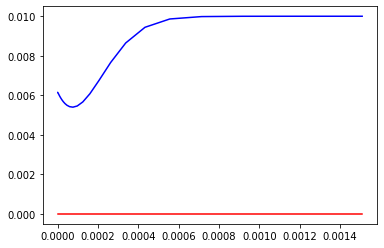

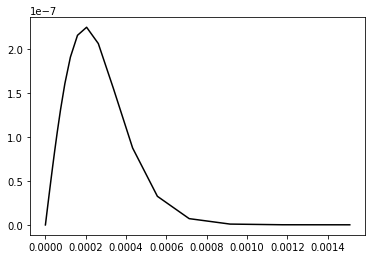

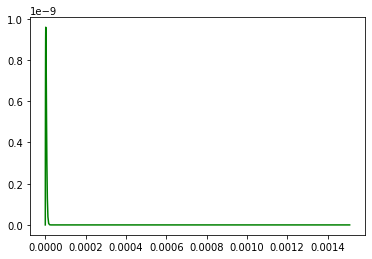

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


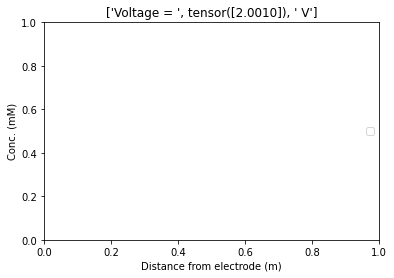

4000 tensor([2.0010])
tensor([2.]) tensor([0.]) 1.9460124158078573e-15 5.566985957294997e-07 0.016886959887261386 6.415259978023757e-20 86026.26587032306 79000000.0
tensor([1.9990]) tensor([-1.4148e-08]) 1.908484149671951e-15 5.676454684408152e-07 0.016561315721671837 6.54140285324531e-20 86026.26587032306 79000000.0
tensor([1.9980]) tensor([0.]) 1.8716849598256164e-15 5.788059435244593e-07 0.016241982180729593 6.670013346263514e-20 86026.26587032306 79000000.0
tensor([1.9970]) tensor([-1.4148e-08]) 1.835591826955163e-15 5.901869703513708e-07 0.015928745231946782 6.801178394012153e-20 86026.26587032306 79000000.0
tensor([1.9960]) tensor([0.]) 1.800198139178341e-15 6.017906338059388e-07 0.015621608848390723 6.934896332806381e-20 86026.26587032306 79000000.0
tensor([1.9950]) tensor([0.]) 1.7654818576604743e-15 6.136241924275534e-07 0.015320365414844224 7.071256786752178e-20 86026.26587032306 79000000.0
tensor([1.9940]) tensor([0.]) 1.7314350692257296e-15 6.256904451154839e-07 0.015024931

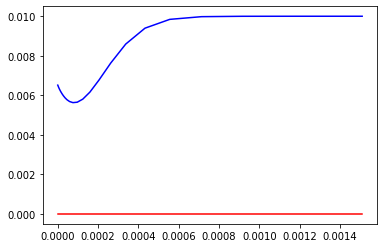

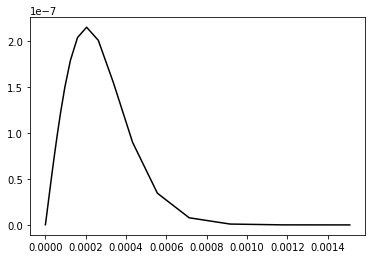

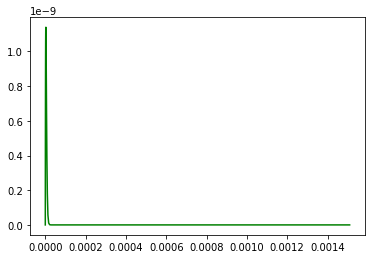

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


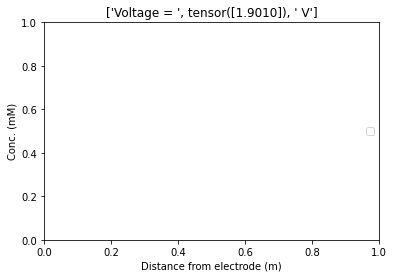

4100 tensor([1.9010])
tensor([1.9000]) tensor([1.4148e-08]) 2.776500931771901e-16 3.901826096132589e-06 0.002409371054413941 4.4963700263923e-19 86026.26587032306 79000000.0
tensor([1.8990]) tensor([0.]) 2.72296473399192e-16 3.978539882021184e-06 0.002362913816161853 4.584773137905252e-19 86026.26587032306 79000000.0
tensor([1.8980]) tensor([0.]) 2.6704557220294124e-16 4.0567696749868575e-06 0.0023173479414774173 4.674923259308761e-19 86026.26587032306 79000000.0
tensor([1.8970]) tensor([0.]) 2.6189567838795906e-16 4.13654164062836e-06 0.0022726564136589878 4.766855089231105e-19 86026.26587032306 79000000.0
tensor([1.8960]) tensor([-1.4148e-08]) 2.568458335723289e-16 4.2178701678154e-06 0.002228835292673465 4.860576206386913e-19 86026.26587032306 79000000.0
tensor([1.8950]) tensor([1.4148e-08]) 2.518926386595413e-16 4.30080999951989e-06 0.0021858549567240256 4.956149427114905e-19 86026.26587032306 79000000.0
tensor([1.8940]) tensor([0.]) 2.470356713996769e-16 4.3853682061959175e-06 0.0

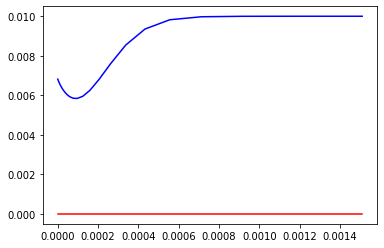

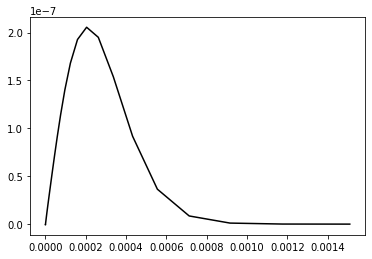

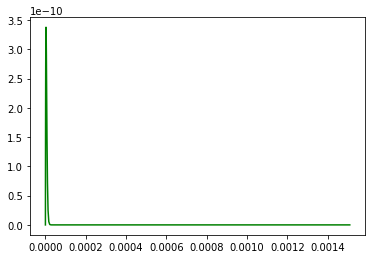

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


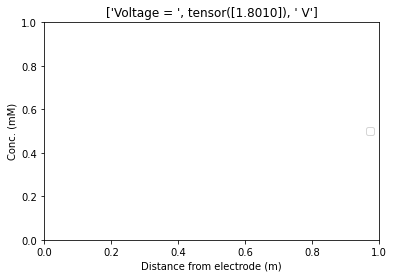

4200 tensor([1.8010])
tensor([1.8000]) tensor([-1.4148e-08]) 3.9614160286681354e-17 2.7347351838646323e-05 0.00034376044691305125 3.1514456909768316e-18 86026.26587032306 79000000.0
tensor([1.7990]) tensor([0.]) 3.8850287180578155e-17 2.788505459733087e-05 0.0003371320942752844 3.2134062509866083e-18 86026.26587032306 79000000.0
tensor([1.7980]) tensor([-1.4148e-08]) 3.8101107373419524e-17 2.843335676663764e-05 0.00033063091820412254 3.27659126689289e-18 86026.26587032306 79000000.0
tensor([1.7970]) tensor([0.]) 3.7366445844356755e-17 2.8992384870235565e-05 0.00032425572775250005 3.3410123135259017e-18 86026.26587032306 79000000.0
tensor([1.7960]) tensor([0.]) 3.664584513656641e-17 2.9562488601781805e-05 0.00031800285650708136 3.4067064398469686e-18 86026.26587032306 79000000.0
tensor([1.7950]) tensor([0.]) 3.593917527168307e-17 3.0143774056105968e-05 0.0003118699693158443 3.473698931413487e-18 86026.26587032306 79000000.0
tensor([1.7940]) tensor([0.]) 3.5246199889115344e-17 3.07364306

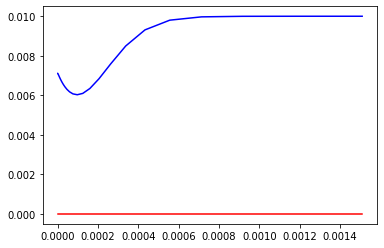

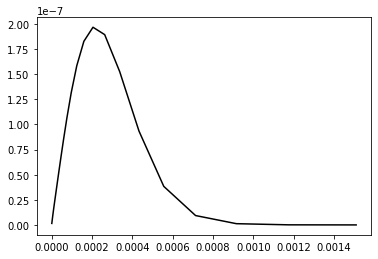

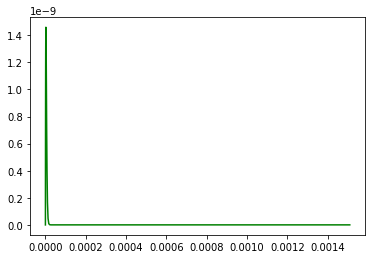

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


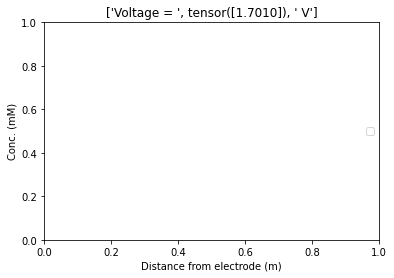

4300 tensor([1.7010])
tensor([1.7000]) tensor([0.]) 5.652017522651295e-18 0.00019167357051013217 4.904665171290193e-05 2.208799869752225e-17 86026.26587032306 79000000.0
tensor([1.6990]) tensor([0.]) 5.543025345116146e-18 0.00019544243652194694 4.810084760851381e-05 2.25223137016125e-17 86026.26587032306 79000000.0
tensor([1.6980]) tensor([0.]) 5.436129762816771e-18 0.000199285599575361 4.7173237180259886e-05 2.2965190517087113e-17 86026.26587032306 79000000.0
tensor([1.6970]) tensor([1.4148e-08]) 5.331310882761838e-18 0.00020320375288097802 4.626364780223914e-05 2.3416709027859498e-17 86026.26587032306 79000000.0
tensor([1.6960]) tensor([-1.4148e-08]) 5.228503136695885e-18 0.0002071993361826719 4.537146722156205e-05 2.387717315514903e-17 86026.26587032306 79000000.0
tensor([1.6950]) tensor([0.]) 5.1276828011796235e-18 0.00021127328291507862 4.4496619381625824e-05 2.4346622152597834e-17 86026.26587032306 79000000.0
tensor([1.6940]) tensor([-1.4148e-08]) 5.028801771180987e-18 0.00021542

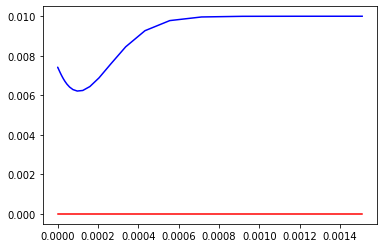

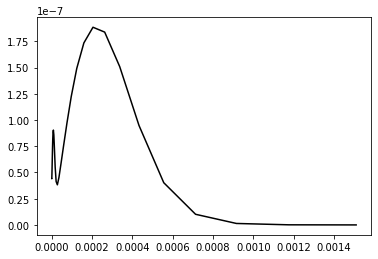

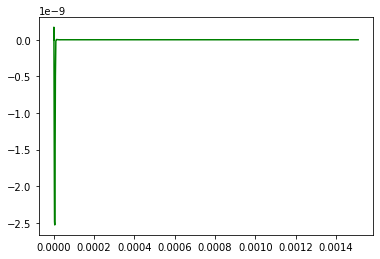

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


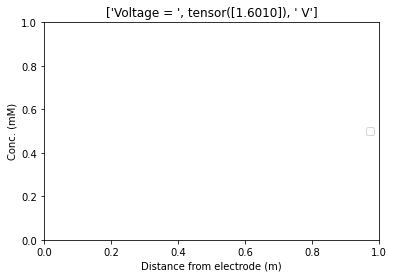

4400 tensor([1.6010])
tensor([1.6000]) tensor([1.4148e-08]) 8.064104193999028e-19 0.0013434131716187198 6.99780089145176e-06 1.5481183245378903e-16 86026.26587032306 79000000.0
tensor([1.5990]) tensor([0.]) 7.908597903996943e-19 0.0013698286248753305 6.8628569437268866e-06 1.5785588830358084e-16 86026.26587032306 79000000.0
tensor([1.5980]) tensor([0.]) 7.75609036074322e-19 0.0013967634836175309 6.730528060825839e-06 1.6095949223625683e-16 86026.26587032306 79000000.0
tensor([1.5970]) tensor([-1.4148e-08]) 7.6065237371103505e-19 0.0014242279608844782 6.600731844599231e-06 1.6412458567587537e-16 86026.26587032306 79000000.0
tensor([1.5960]) tensor([-1.4148e-08]) 7.459841321095553e-19 0.0014522324705337102 6.47344488305227e-06 1.6735175763813758e-16 86026.26587032306 79000000.0
tensor([1.5950]) tensor([0.]) 7.316001448469043e-19 0.0014807848068142566 6.348624602384929e-06 1.7064205981645792e-16 86026.26587032306 79000000.0
tensor([1.5940]) tensor([-1.4148e-08]) 7.174921395988084e-19 0.00

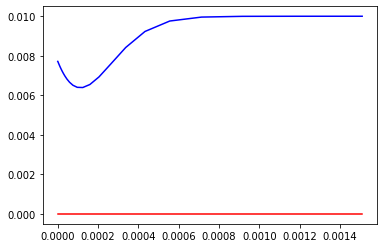

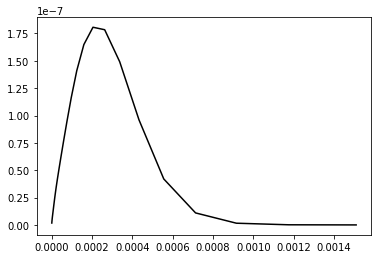

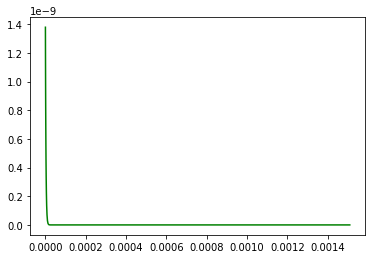

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


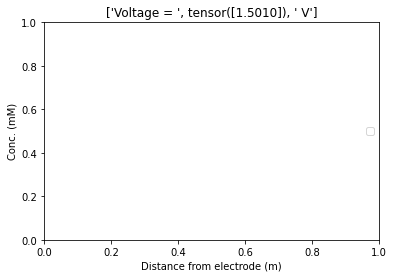

4500 tensor([1.5010])
tensor([1.5000]) tensor([0.]) 1.1505575517743618e-19 0.009415803472687662 9.984221614913743e-07 1.0850544197999206e-15 86026.26587032306 79000000.0
tensor([1.4990]) tensor([1.4148e-08]) 1.1283704703570042e-19 0.00960094585610387 9.791678893767327e-07 1.1063908354286237e-15 86026.26587032306 79000000.0
tensor([1.4980]) tensor([0.]) 1.106613350098603e-19 0.009789710010780875 9.602876775296482e-07 1.1281435808270676e-15 86026.26587032306 79000000.0
tensor([1.4970]) tensor([0.]) 1.0852716083450335e-19 0.009982223535769356 9.417697156488382e-07 1.1503262009290987e-15 86026.26587032306 79000000.0
tensor([1.4960]) tensor([0.]) 1.0643455157928944e-19 0.010178483989246286 9.236097306151918e-07 1.1729438779632824e-15 86026.26587032306 79000000.0
tensor([1.4950]) tensor([0.]) 1.0438209270153241e-19 0.010378622914277909 9.057990576424052e-07 1.196007403642157e-15 86026.26587032306 79000000.0
tensor([1.4940]) tensor([0.]) 1.0236921295839265e-19 0.010582697159083594 8.883309943

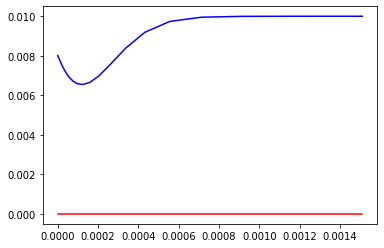

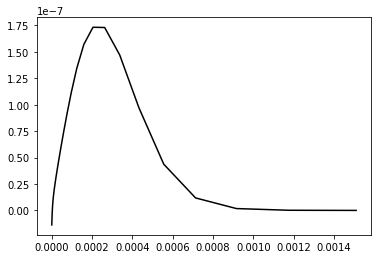

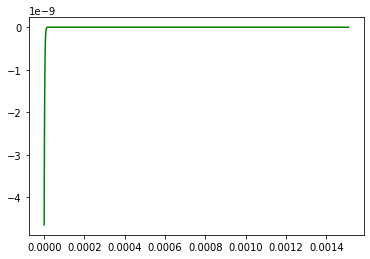

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


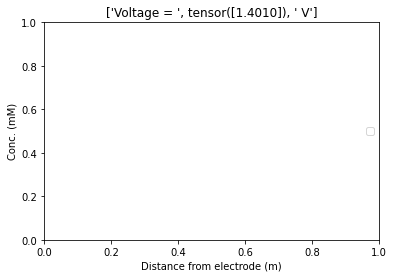

4600 tensor([1.4010])
tensor([1.4000]) tensor([0.]) 1.6415743746591442e-20 0.0659941088186973 1.4245130396723153e-07 7.605001491608738e-15 86026.26587032306 79000000.0
tensor([1.3990]) tensor([0.]) 1.6099217109100933e-20 0.06729161870486168 1.3970457296637454e-07 7.754523392825192e-15 86026.26587032306 79000000.0
tensor([1.3980]) tensor([-2.8295e-08]) 1.5788763590105308e-20 0.0686147697994115 1.3701041215213905e-07 7.907007665588513e-15 86026.26587032306 79000000.0
tensor([1.3970]) tensor([0.]) 1.5484296783805314e-20 0.06996393793520217 1.3436833556522064e-07 8.062482686827397e-15 86026.26587032306 79000000.0
tensor([1.3960]) tensor([2.8295e-08]) 1.518570124384036e-20 0.07133963468376751 1.3177745950756488e-07 8.2209991238313e-15 86026.26587032306 79000000.0
tensor([1.3950]) tensor([0.]) 1.4892863750090345e-20 0.07274238167564204 1.292361707002884e-07 8.382656134750269e-15 86026.26587032306 79000000.0
tensor([1.3940]) tensor([-2.8295e-08]) 1.4605701123882852e-20 0.0741725693250667 1.26

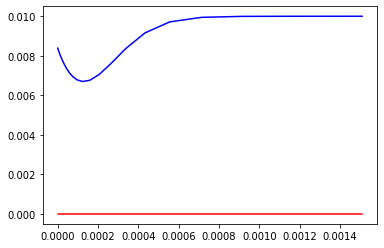

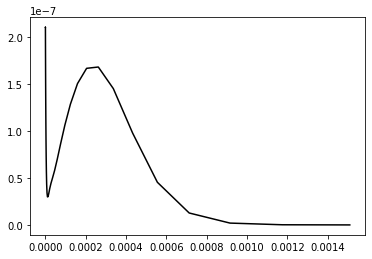

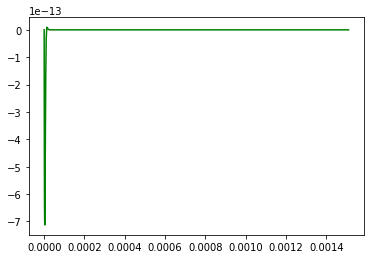

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


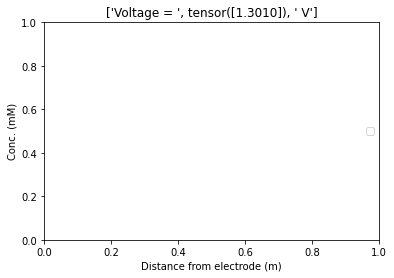

4700 tensor([1.3010])
tensor([1.3000]) tensor([2.8295e-08]) 2.342139620379491e-21 0.4625438935091642 2.032445238175953e-08 5.3302414195654624e-14 86026.26587032306 79000000.0
tensor([1.2990]) tensor([0.]) 2.2969787315391085e-21 0.47163796698566013 1.9932558437108367e-08 5.435039272909147e-14 86026.26587032306 79000000.0
tensor([1.2980]) tensor([-2.8295e-08]) 2.252684333530071e-21 0.4809117562666904 1.9548165022286916e-08 5.5419134119099345e-14 86026.26587032306 79000000.0
tensor([1.2970]) tensor([-2.8295e-08]) 2.209248312084629e-21 0.49036696021289355 1.917123936852853e-08 5.6508729473735433e-14 86026.26587032306 79000000.0
tensor([1.2960]) tensor([0.]) 2.1666456868654127e-21 0.5000090165733223 1.880153672901405e-08 5.761988473424192e-14 86026.26587032306 79000000.0
tensor([1.2950]) tensor([0.]) 2.124860547804469e-21 0.5098416365590572 1.8438963521198608e-08 5.87528891147773e-14 86026.26587032306 79000000.0
tensor([1.2940]) tensor([0.]) 2.083889211097751e-21 0.5198656307557359 1.808342

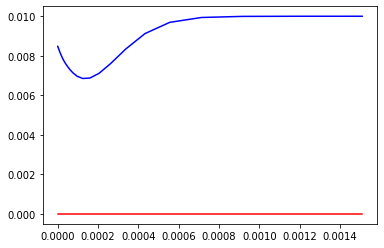

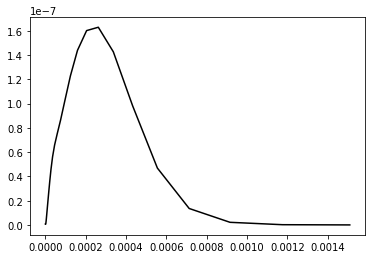

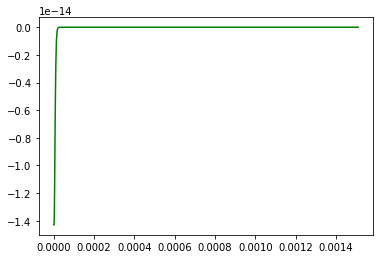

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


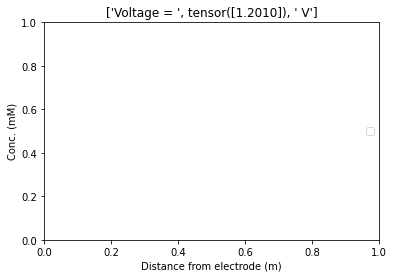

4800 tensor([1.2010])
tensor([1.2000]) tensor([0.]) 3.3416938105544707e-22 3.2418959981634337 2.8998271058871844e-09 3.735886104909566e-13 86026.26587032306 79000000.0
tensor([1.1990]) tensor([0.]) 3.277247121638238e-22 3.30564751128948 2.8439061654318658e-09 3.8093464275319817e-13 86026.26587032306 79000000.0
tensor([1.1980]) tensor([0.]) 3.21404945838319e-22 3.3706462616084782 2.7890636174003784e-09 3.8842512318244065e-13 86026.26587032306 79000000.0
tensor([1.1970]) tensor([0.]) 3.152076496116313e-22 3.4369165230831045 2.7352851872426723e-09 3.960619478382355e-13 86026.26587032306 79000000.0
tensor([1.1960]) tensor([0.]) 3.091292593785465e-22 3.5044964081701195 2.6825373114215326e-09 4.03849882922344e-13 86026.26587032306 79000000.0
tensor([1.1950]) tensor([0.]) 3.0316866164191694e-22 3.5733982967935476 2.630811655777943e-09 4.1179017006903764e-13 86026.26587032306 79000000.0
tensor([1.1940]) tensor([0.]) 2.9732186132637716e-22 3.6436687646159833 2.580078471839756e-09 4.198873758982

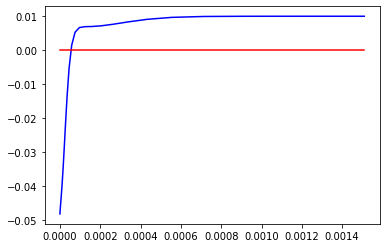

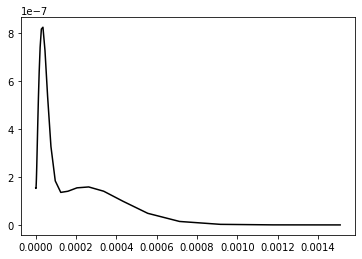

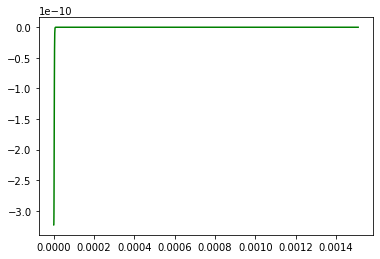

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


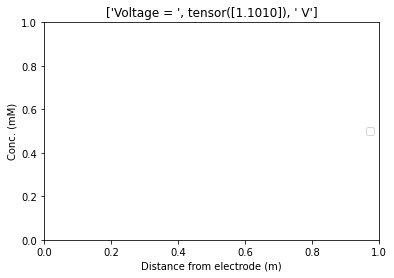

4900 tensor([1.1010])
tensor([1.1000]) tensor([-1.0186e-06]) 4.7678092407489475e-23 22.72201601300285 4.137371599104291e-10 2.6184314200516596e-12 86026.26587032306 79000000.0
tensor([1.0990]) tensor([-7.9227e-07]) 4.6758679279099763e-23 23.168797661841545 4.057585562769462e-10 2.669918754376141e-12 86026.26587032306 79000000.0
tensor([1.0980]) tensor([-1.1318e-07]) 4.585699589739183e-23 23.624364351656578 3.9793466776612654e-10 2.7224126644555263e-12 86026.26587032306 79000000.0
tensor([1.0970]) tensor([5.6591e-07]) 4.497270036609762e-23 24.088888822185915 3.9026080306706257e-10 2.775944626358603e-12 86026.26587032306 79000000.0
tensor([1.0960]) tensor([-1.1318e-07]) 4.410545738199635e-23 24.56254720973874 3.8273492295991696e-10 2.830529210071226e-12 86026.26587032306 79000000.0
tensor([1.0950]) tensor([7.9227e-07]) 4.32550206101015e-23 25.0454713434909 3.753549790989385e-10 2.88618092066617e-12 86026.26587032306 79000000.0
tensor([1.0940]) tensor([1.3582e-06]) 4.242090095871529e-23 2

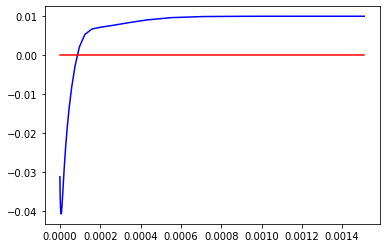

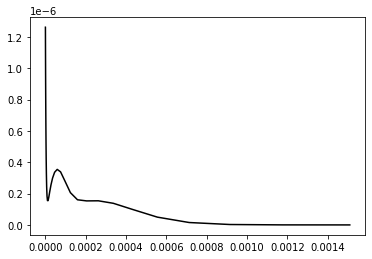

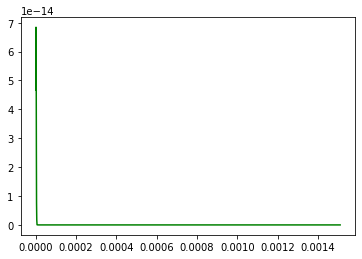

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


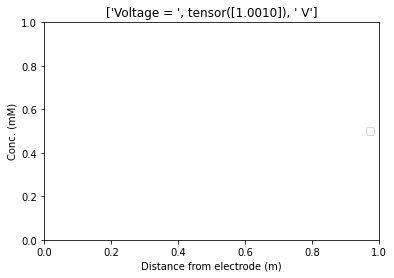

5000 tensor([1.0010])
tensor([1.]) tensor([1.4035e-05]) 6.802539743280442e-24 159.25557512876458 5.90305526598842e-11 1.835223168914392e-11 86026.26587032306 79000000.0
tensor([1.]) tensor([3.3955e-06]) 6.802539743280442e-24 159.25557512876458 5.90305526598842e-11 1.835223168914392e-11 86026.26587032306 79000000.0
tensor([1.0010]) tensor([3.1691e-05]) 6.936297677481985e-24 156.18452804719885 6.01912991934691e-11 1.7998321911449136e-11 86026.26587032306 79000000.0
tensor([1.0020]) tensor([2.5353e-05]) 7.072672195920242e-24 153.1729944698008 6.137473103951182e-11 1.7651277012602655e-11 86026.26587032306 79000000.0
tensor([1.0030]) tensor([5.0706e-05]) 7.211755483783232e-24 150.21895592390388 6.258157229533208e-11 1.731088464891783e-11 86026.26587032306 79000000.0
tensor([1.0040]) tensor([-1.8109e-06]) 7.353545776951913e-24 147.32244987824865 6.381199592275005e-11 1.6977095975243983e-11 86026.26587032306 79000000.0
tensor([1.0050]) tensor([-1.3582e-06]) 7.498138110007101e-24 144.481518379

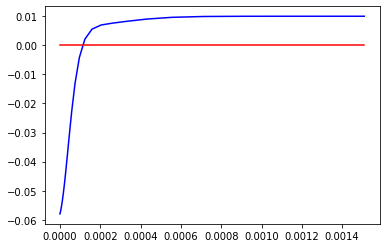

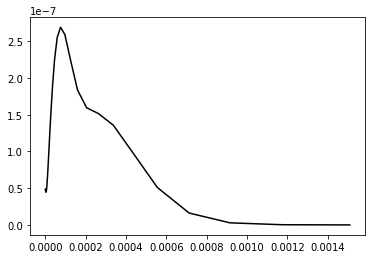

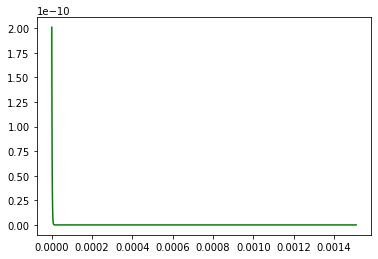

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


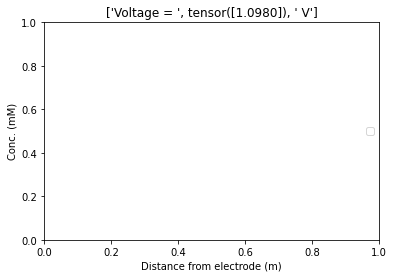

5100 tensor([1.0980])
tensor([1.0990]) tensor([-1.1318e-07]) 4.6758679279099763e-23 23.168797661841545 4.057585562769462e-10 2.669918754376141e-12 86026.26587032306 79000000.0
tensor([1.1000]) tensor([-1.1318e-07]) 4.7678092407489475e-23 22.72201601300285 4.137371599104291e-10 2.6184314200516596e-12 86026.26587032306 79000000.0
tensor([1.1010]) tensor([-3.3955e-06]) 4.861549117473595e-23 22.28389249958636 4.2187164441013125e-10 2.5679431019052125e-12 86026.26587032306 79000000.0
tensor([1.1020]) tensor([-9.0546e-07]) 4.957141468494394e-23 21.85417515392078 4.301671891310376e-10 2.5184216893455287e-12 86026.26587032306 79000000.0
tensor([1.1030]) tensor([-1.1318e-07]) 5.0546134462252953e-23 21.432744376554215 4.386257501277488e-10 2.469855859663698e-12 86026.26587032306 79000000.0
tensor([1.1040]) tensor([1.1318e-07]) 5.1540020096544595e-23 21.019440371251157 4.472495690913558e-10 2.422232359783718e-12 86026.26587032306 79000000.0
tensor([1.1050]) tensor([0.]) 5.2553448444924254e-23 20.

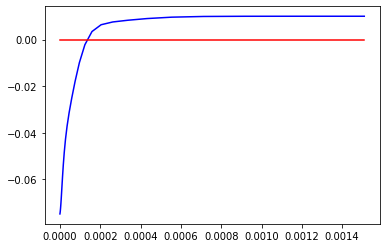

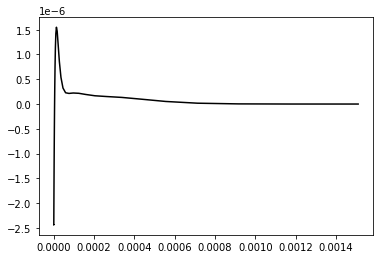

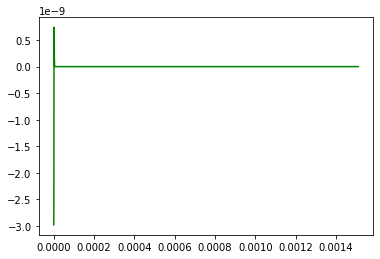

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


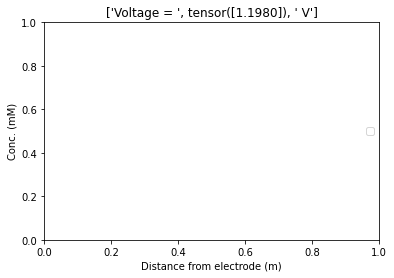

5200 tensor([1.1980])
tensor([1.1990]) tensor([-2.2636e-07]) 3.277247121638238e-22 3.30564751128948 2.8439061654318658e-09 3.8093464275319817e-13 86026.26587032306 79000000.0
tensor([1.2000]) tensor([0.]) 3.3416938105544707e-22 3.2418959981634337 2.8998271058871844e-09 3.735886104909566e-13 86026.26587032306 79000000.0
tensor([1.2010]) tensor([2.2636e-07]) 3.407394838014975e-22 3.1793861018569873 2.9568420039227925e-09 3.6638493964681013e-13 86026.26587032306 79000000.0
tensor([1.2020]) tensor([0.]) 3.47439423996512e-22 3.1180755675075065 3.0149836499612584e-09 3.59319487243762e-13 86026.26587032306 79000000.0
tensor([1.2030]) tensor([0.]) 3.5427042899905263e-22 3.0579531636700685 3.0742612303767448e-09 3.5239112683330554e-13 86026.26587032306 79000000.0
tensor([1.2040]) tensor([0.]) 3.6123642736435665e-22 2.9989843135606735 3.1347117407689836e-09 3.45595534371734e-13 86026.26587032306 79000000.0
tensor([1.2050]) tensor([0.]) 3.6834010029333757e-22 2.94114699509952 3.1963509153419292e-

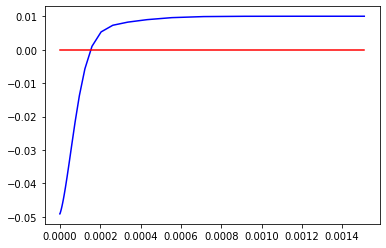

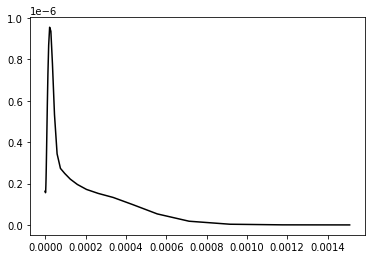

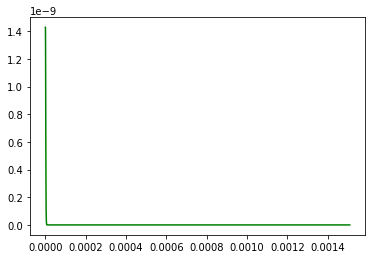

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


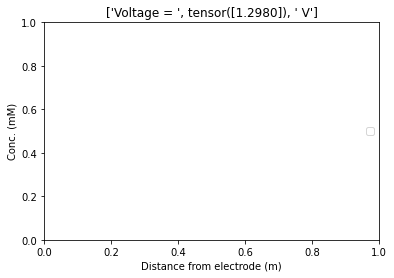

5300 tensor([1.2980])
tensor([1.2990]) tensor([1.1318e-07]) 2.2969787315391085e-21 0.47163796698566013 1.9932558437108367e-08 5.435039272909147e-14 86026.26587032306 79000000.0
tensor([1.3000]) tensor([-3.3955e-07]) 2.342139620379491e-21 0.4625438935091642 2.032445238175953e-08 5.3302414195654624e-14 86026.26587032306 79000000.0
tensor([1.3010]) tensor([0.]) 2.3881975274919483e-21 0.45362344055774845 2.0724100761597945e-08 5.22745180413258e-14 86026.26587032306 79000000.0
tensor([1.3020]) tensor([0.]) 2.4351565133704346e-21 0.44487587274338286 2.1131607598063253e-08 5.126644407554187e-14 86026.26587032306 79000000.0
tensor([1.3030]) tensor([1.1318e-07]) 2.4830341149778155e-21 0.4362978231421054 2.1547076043047626e-08 5.027792991439117e-14 86026.26587032306 79000000.0
tensor([1.3040]) tensor([-1.1318e-07]) 2.531857867032989e-21 0.4278843584620108 2.197076539364422e-08 4.9308358618484834e-14 86026.26587032306 79000000.0
tensor([1.3050]) tensor([0.]) 2.581636713533718e-21 0.41963393744487

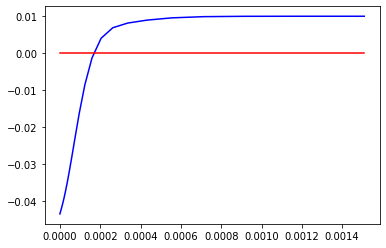

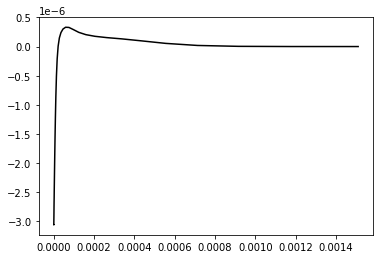

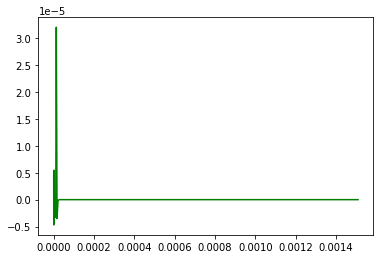

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


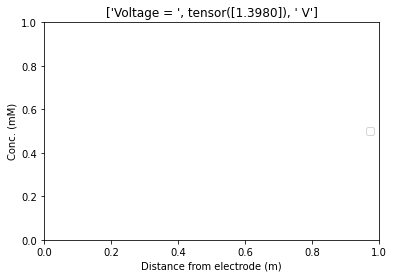

5400 tensor([1.3980])
tensor([1.3990]) tensor([1.1318e-07]) 1.6099217109100933e-20 0.06729161870486168 1.3970457296637454e-07 7.754523392825192e-15 86026.26587032306 79000000.0
tensor([1.4000]) tensor([0.]) 1.6415743746591442e-20 0.0659941088186973 1.4245130396723153e-07 7.605001491608738e-15 86026.26587032306 79000000.0
tensor([1.4010]) tensor([-1.1318e-07]) 1.673852553909694e-20 0.06472149393457584 1.452524540043477e-07 7.458341317386478e-15 86026.26587032306 79000000.0
tensor([1.4020]) tensor([0.]) 1.7067654170782038e-20 0.06347341985678205 1.4810826187013832e-07 7.314530367673092e-15 86026.26587032306 79000000.0
tensor([1.4030]) tensor([0.]) 1.7403254439167858e-20 0.06224941334617446 1.5102050581042544e-07 7.17347868316846e-15 86026.26587032306 79000000.0
tensor([1.4040]) tensor([0.]) 1.774545359566177e-20 0.06104901028944394 1.5399015988641398e-07 7.0351402969611746e-15 86026.26587032306 79000000.0
tensor([1.4050]) tensor([-1.1318e-07]) 1.8094346881547303e-20 0.05987186971955331 1

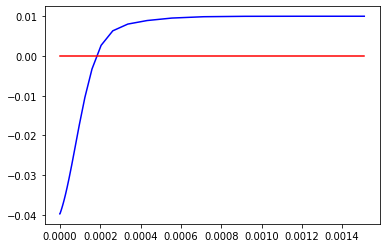

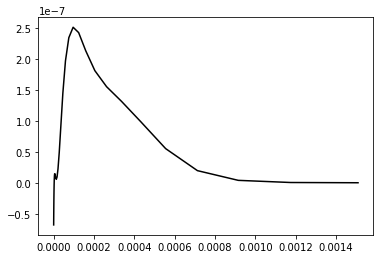

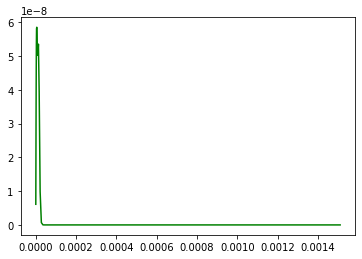

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


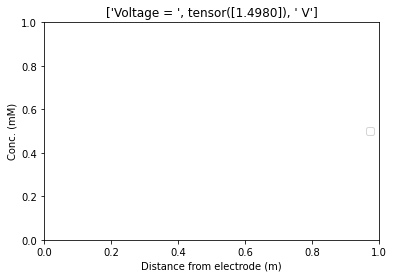

5500 tensor([1.4980])
tensor([1.4990]) tensor([0.]) 1.1283704703570042e-19 0.00960094585610387 9.791678893767327e-07 1.1063908354286237e-15 86026.26587032306 79000000.0
tensor([1.5000]) tensor([0.]) 1.1505575517743618e-19 0.009415803472687662 9.984221614913743e-07 1.0850544197999206e-15 86026.26587032306 79000000.0
tensor([1.5010]) tensor([0.]) 1.1731808964534343e-19 0.009234231331479962 1.0180540770438033e-06 1.0641304853846118e-15 86026.26587032306 79000000.0
tensor([1.5020]) tensor([0.]) 1.1962468009509014e-19 0.009056177858041099 1.0380700338202367e-06 1.0436120337329847e-15 86026.26587032306 79000000.0
tensor([1.5030]) tensor([0.]) 1.219770857143949e-19 0.00888152371248657 1.0584825525742497e-06 1.0234862884774964e-15 86026.26587032306 79000000.0
tensor([1.5040]) tensor([0.]) 1.2437527666557127e-19 0.008710271110112747 1.0792933734320728e-06 1.0037515339387816e-15 86026.26587032306 79000000.0
tensor([1.5050]) tensor([0.]) 1.2682086032996153e-19 0.008542304289166419 1.1005165043466

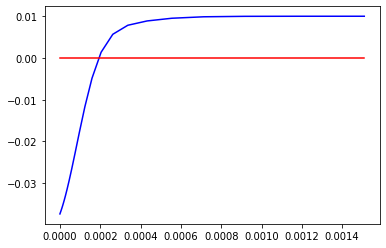

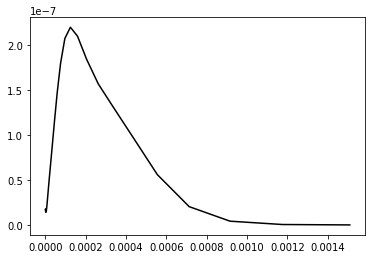

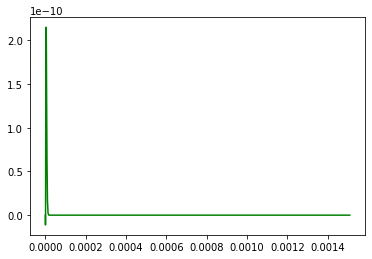

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


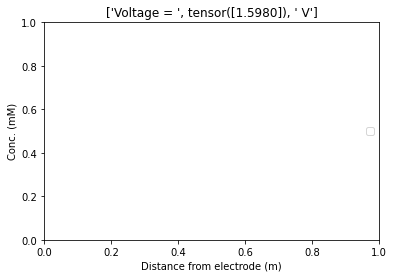

5600 tensor([1.5980])
tensor([1.5990]) tensor([0.]) 7.908597903996943e-19 0.0013698286248753305 6.8628569437268866e-06 1.5785588830358084e-16 86026.26587032306 79000000.0
tensor([1.6000]) tensor([0.]) 8.064104193999028e-19 0.0013434131716187198 6.99780089145176e-06 1.5481183245378903e-16 86026.26587032306 79000000.0
tensor([1.6010]) tensor([0.]) 8.222652511448372e-19 0.0013175096207021656 7.13539142914841e-06 1.5182662225465318e-16 86026.26587032306 79000000.0
tensor([1.6020]) tensor([0.]) 8.384334038509627e-19 0.0012921030748256983 7.275694206243546e-06 1.48898833354314e-16 86026.26587032306 79000000.0
tensor([1.6030]) tensor([0.]) 8.549194699816972e-19 0.0012671864628087117 7.4187628235764774e-06 1.460273639844092e-16 86026.26587032306 79000000.0
tensor([1.6040]) tensor([0.]) 8.717297006497924e-19 0.001242750336881806 7.564623087151579e-06 1.4321167977191744e-16 86026.26587032306 79000000.0
tensor([1.6050]) tensor([0.]) 8.888704698832575e-19 0.0012187854314641474 7.71336582079752e-06

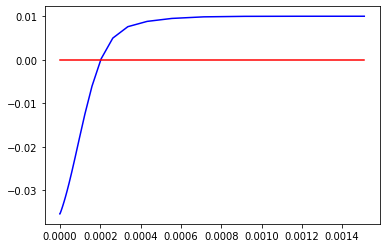

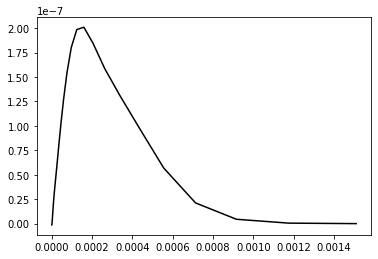

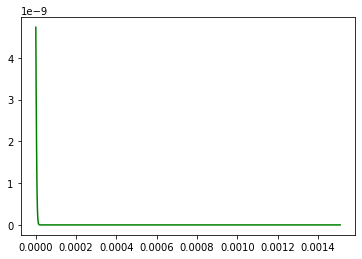

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


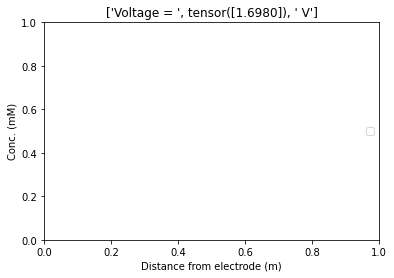

5700 tensor([1.6980])
tensor([1.6990]) tensor([1.1318e-07]) 5.543025345116146e-18 0.00019544243652194694 4.810084760851381e-05 2.25223137016125e-17 86026.26587032306 79000000.0
tensor([1.7000]) tensor([0.]) 5.652017522651295e-18 0.00019167357051013217 4.904665171290193e-05 2.208799869752225e-17 86026.26587032306 79000000.0
tensor([1.7010]) tensor([1.1318e-07]) 5.763147310719777e-18 0.0001879775616939945 5.00109577186938e-05 2.1662100239033388e-17 86026.26587032306 79000000.0
tensor([1.7020]) tensor([0.]) 5.876467733366703e-18 0.0001843526465739215 5.099436883651803e-05 2.1244353128979286e-17 86026.26587032306 79000000.0
tensor([1.7030]) tensor([0.]) 5.992004939887916e-18 0.0001807979783095222 5.199696890019748e-05 2.0834721755257754e-17 86026.26587032306 79000000.0
tensor([1.7040]) tensor([1.1318e-07]) 6.1098312032658094e-18 0.00017731134349069092 5.3019432768960806e-05 2.0432930391262633e-17 86026.26587032306 79000000.0
tensor([1.7050]) tensor([0.]) 6.229968450663184e-18 0.00017389211

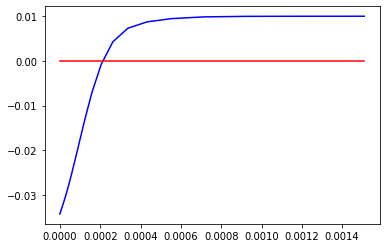

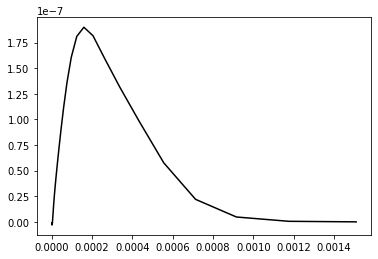

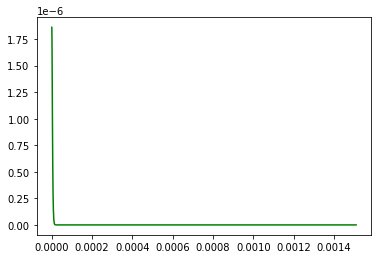

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


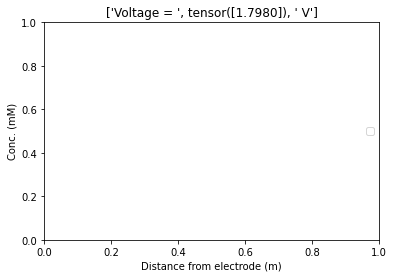

5800 tensor([1.7980])
tensor([1.7990]) tensor([0.]) 3.8850287180578155e-17 2.788505459733087e-05 0.0003371320942752844 3.2134062509866083e-18 86026.26587032306 79000000.0
tensor([1.8000]) tensor([0.]) 3.9614160286681354e-17 2.7347351838646323e-05 0.00034376044691305125 3.1514456909768316e-18 86026.26587032306 79000000.0
tensor([1.8010]) tensor([0.]) 4.039309116324247e-17 2.681999193313143e-05 0.00035051978812597224 3.0906739529440384e-18 86026.26587032306 79000000.0
tensor([1.8020]) tensor([0.]) 4.1187377390606034e-17 2.630277642779685e-05 0.00035741271957297465 3.0310683415149533e-18 86026.26587032306 79000000.0
tensor([1.8030]) tensor([-1.1318e-07]) 4.1997162238164337e-17 2.579560907017506e-05 0.00036443980949642317 2.9726236018215183e-18 86026.26587032306 79000000.0
tensor([1.8040]) tensor([0.]) 4.2822949940302024e-17 2.5298172607507308e-05 0.00037160576778533976 2.9153002269281363e-18 86026.26587032306 79000000.0
tensor([1.8050]) tensor([1.1318e-07]) 4.366493341474473e-17 2.4810352

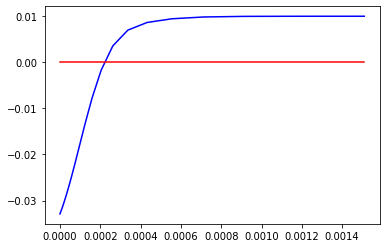

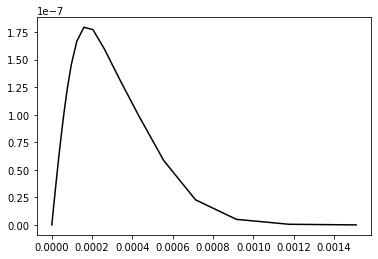

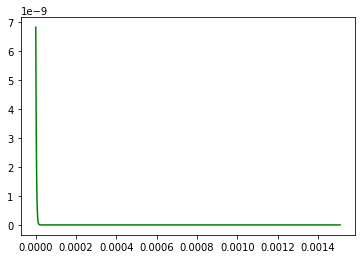

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


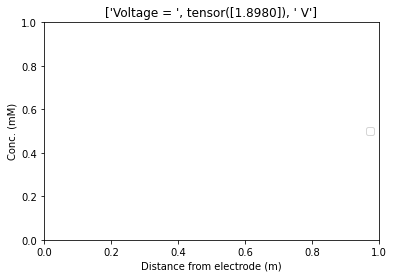

5900 tensor([1.8980])
tensor([1.8990]) tensor([0.]) 2.72296473399192e-16 3.978539882021184e-06 0.002362913816161853 4.584773137905252e-19 86026.26587032306 79000000.0
tensor([1.9000]) tensor([1.1318e-07]) 2.776500931771901e-16 3.901826096132589e-06 0.002409371054413941 4.4963700263923e-19 86026.26587032306 79000000.0
tensor([1.9010]) tensor([0.]) 2.8310978043275575e-16 3.826580549412424e-06 0.002456746374092409 4.409663083567681e-19 86026.26587032306 79000000.0
tensor([1.9020]) tensor([0.]) 2.8867600059326276e-16 3.7527968273289456e-06 0.0025050484538574483 4.3246364256316053e-19 86026.26587032306 79000000.0
tensor([1.9030]) tensor([0.]) 2.943525003321657e-16 3.680425265387229e-06 0.0025543099445030307 4.241233063684376e-19 86026.26587032306 79000000.0
tensor([1.9040]) tensor([-1.1318e-07]) 3.0014033603138093e-16 3.609452809565514e-06 0.002604535188953042 4.15944612208477e-19 86026.26587032306 79000000.0
tensor([1.9050]) tensor([0.]) 3.0604139387136624e-16 3.539855721634017e-06 0.00265

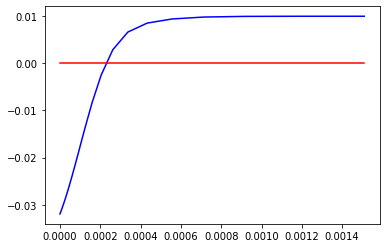

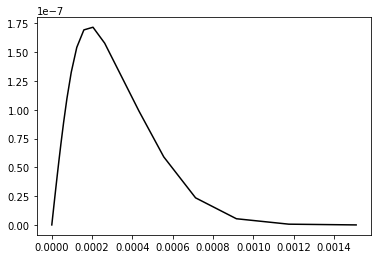

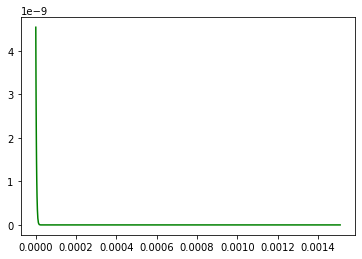

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


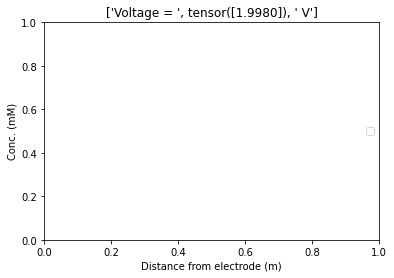

6000 tensor([1.9980])
tensor([1.9990]) tensor([1.1318e-07]) 1.908484149671951e-15 5.676454684408152e-07 0.016561315721671837 6.54140285324531e-20 86026.26587032306 79000000.0
tensor([2.]) tensor([1.1318e-07]) 1.9460124158078573e-15 5.566985957294997e-07 0.016886959887261386 6.415259978023757e-20 86026.26587032306 79000000.0
tensor([2.0010]) tensor([1.1318e-07]) 1.9842729574426578e-15 5.459643921915981e-07 0.0172189743320837 6.2915616125511e-20 86026.26587032306 79000000.0


In [ ]:
for E in Evt:
  k1f = ks1 * math.exp((E-E10)*VT) * dx1 / DR
  k1b = ks1 * math.exp(-(E-E10)*VT) * dx1 / DP
  k3f = ks2 * math.exp((E-E20)*VT) * dx1 / DR
  k3b = ks2 * math.exp(-(E-E20)*VT) * dx1 / DP
  
  #set values for row 0
  Dopt[0] = 0
  Dopt[0, 0] = 1 + k1f
  Dopt[0, 1] = -1
  Dopt[0, N+1] = - k1b

  #set values for row 2*(N+1)
  Dopt[2*N+2] = 0
  Dopt[2*(N+1), 2*(N+1)] = 1 + k3f
  Dopt[2*(N+1), 2*(N+1)+1] = -1
  Dopt[2*(N+1), 3*(N+1)] = -k3b


  for i in range(N+2, 2*N+1):
    Dopt[i] = 0
    Dopt[i, i] = D3[i-N-2] + k2fs
    Dopt[i, i-1] = -D1[i-N-2]
    Dopt[i, i+1] = -D2[i-N-2]
    Dopt[i, i+N+1] = -k2bs * Cold2[i-N-1]
    Dopt[i, i+2*N+2] = -k2bs * Cold1[i-N-1]

  for i in range(2*N+3, 3*N+2):
    Dopt[i] = 0
    Dopt[i, i] = D3[i-2*N-3] + k2bs * Cold2[i-2*N-2]
    Dopt[i, i-1] = -D1[i-2*N-3]
    Dopt[i, i+1] = -D2[i-2*N-3]
    Dopt[i, i-N-1] = -k2fs
    Dopt[i, i+N+1] = k2bs * Cold1[i-2*N-2]

  for i in range(3*N+4, 4*N+3):
    Dopt[i] = 0
    Dopt[i, i] = D3[i-3*N-4] + k2bs * Cold1[i-3*N-3]
    Dopt[i, i-1] = -D1[i-3*N-4]
    Dopt[i, i+1] = -D2[i-3*N-4]
    Dopt[i, i-N-1] = k2bs * Cold2[i-3*N-3]

  Cnew, LU = torch.solve(Cold, Dopt)

  Istor[count,:] = DR*(Cnew[1] - Cnew[0])/dx1
  print(E, Istor[count,:], k1f, k1b, k3f, k3b, k2fs, k2bs)

  if count % 100 == 0:
         plt.figure(count)
         plt.plot(x[0:(N+1)],Cnew[0:(N+1)],'-b')
         plt.plot(x[(N+1):(2*N+2)],Cnew[(N+1):(2*N+2)],'-r')
         plt.show()
         plt.plot(x[(2*N+2):(3*N+3)],Cnew[(2*N+2):(3*N+3)],'-k')
         plt.show()
         plt.plot(x[(3*N+3):(4*N+4)],Cnew[(3*N+3):(4*N+4)],'-g')
         plt.show()
         plt.title(['Voltage = ',E,' V'])
         plt.ylabel('Conc. (mM)')
         plt.xlabel('Distance from electrode (m)')
         plt.legend((1,2),('Reactant','Product'),loc=5)
         plt.show()
         print(count,E)
  
  for i in range(0, N+1):
    Cold[0:N] = Cnew[0:N]
    Cold0[0:N] = Cnew[(N+1) : (2*N+1)]
    Cold1[0:N] = Cnew[(2*N+2) : (3*N+2)]
    Cold2[0:N] = Cnew[(3*N+3) : (4*N+3)]
    Cold[(N+1) : (2*N+1)] = Cold0[0:N] - k2bs * Cold1[0:N] * Cold2[0:N]
    Cold[(2*N+2) : (3*N+2)] = Cold1[0:N] + k2bs * Cold1[0:N] * Cold2[0:N]
    Cold[(3*N+3) : (4*N+3)] = Cold2[0:N] + k2bs * Cold1[0:N] * Cold2[0:N]
  
  Cold[0] = 0
  Cold[N+1] = 0
  Cold[2*N+2] = 0
  Cold[3*N+3] = 0
  Cold[N] = CR0
  Cold[2*N+1] = CP00
  Cold[3*N+2] = CP10
  Cold[4*N+3] = CP20

  count = count + 1

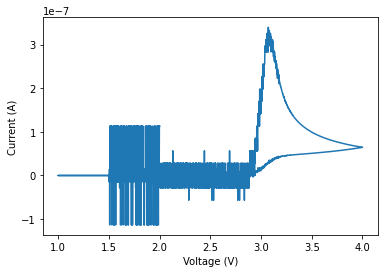

In [ ]:
plt.figure(2)    
plt.plot(Evt,Istor)
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.show()

In [ ]:
max_val, max_idx = Istor.max(0)
print(max_val)
print ('max Evt =', Evt[max_idx], 'max Istor =', Istor[max_idx])

tensor([4.8944e-08])
max Evt = tensor([[3.0130]]) max Istor = tensor([[4.8944e-08]])


In [ ]:
Evt_tensor = torch.Tensor(Evt).view(-1)
Istor_tensor = torch.Tensor(Istor).view(-1)
Istor_tensor[Evt_tensor.le(1.5)] = 0
max_val, max_idx = Istor_tensor.max(0)
print ('max Evt', Evt_tensor[max_idx], 'max Istor', Istor_tensor[max_idx])

max Evt tensor(3.0720) max Istor tensor(3.3955e-07)
